In [1]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
import uproot
import awkward
import numpy as np
import matplotlib.pyplot as plt
from FireHydrant.Tools.metfilter import MetFilters
from FireHydrant.Tools.correction import get_pu_weights_function, get_ttbar_weight, get_nlo_weight_function

np.seterr(divide='ignore', invalid='ignore', over='ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

loading datasets

In [2]:
import json

########## backgrounds ##########
bkgdatasets_=json.load(open('../../MC/Samples/backgrounds_nonempty.json'))
bkgscales_=json.load(open('../../MC/Samples/backgrounds_scale.json'))

# flatten datasets
bkgdatasets = {}
for group in bkgdatasets_:
    for tag in bkgdatasets_[group]:
        bkgdatasets[tag] = bkgdatasets_[group][tag]

# flatten scales
bkgscales = {}
for group in bkgscales_:
    for tag in bkgscales_[group]:
        bkgscales[tag] = bkgscales_[group][tag]

lumi = 59.74*1e3
for k in bkgscales:
    bkgscales[k] *= lumi

# mapping
bkgmapping = {}
for k in bkgdatasets_: bkgmapping[k] = list(bkgdatasets_[k])
####################################

########## data ##########
datadatasets_=json.load(open('../Samples/control_data2018.json'))
datadatasets = datadatasets_
datamapping = {'data': list('ABCD')}
####################################

########## combine together ##########
datasets = {}
datasets.update(bkgdatasets)
datasets.update(datadatasets)

mapping = {}
mapping.update(bkgmapping)
mapping.update(datamapping)
####################################

data/mc re

In [3]:
# using regular expressions on dataset name to select just the data
# another method would be to fill a separate data histogram
import re
notdata = re.compile('(?!data)')

plotopts

In [4]:
# common plotting options

fill_opts = {
    'edgecolor': (0,0,0,0.3),
    'alpha': 0.8
}
error_opts = {
    'label':'Stat. Unc.',
    'hatch':'xxx',
    'facecolor':'none',
    'edgecolor':(0,0,0,.5),
    'linewidth': 0
}
data_err_opts = {
    'linestyle':'none',
    'marker': '.',
    'markersize': 10.,
    'color':'k',
    'elinewidth': 1,
    'emarker': '_'
}

processor

In [29]:
class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset list')
        multiplicity_axis = hist.Bin("multiplicity", "#leptonJets/event", 10, 0, 10)
        pt_axis = hist.Bin("pt", "$p_T$[GeV]", 80, 0, 800)
        mass_axis = hist.Bin("mass", "mass [GeV]", 50, 0, 100)
        
        self._accumulator = processor.dict_accumulator({
            'multi': hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "pt": hist.Hist("#counts/10GeV", dataset_axis, pt_axis),
            "mass": hist.Hist("#counts/2GeV", dataset_axis, mass_axis),
            'events': processor.defaultdict_accumulator(float),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        dataset = df['dataset']
        if dataset.startswith('TTJets_'): return output # skip TTJets_
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)

        
        if len(dataset)!=1: # => MC
            wgts.add('genw', df['weight'])

            nvtx = df['trueInteractionNum']
            pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
            wgts.add('pileup', pu, puUp, puDown)

            wnlo = np.ones_like(df.size)
            if 'TTJets' in dataset or 'WJets' in dataset or 'DYJets' in dataset:
                genparticles = JaggedCandidateArray.candidatesfromcounts(
                    df['gen_p4'],
                    px=df['gen_p4.fCoordinates.fX'],
                    py=df['gen_p4.fCoordinates.fY'],
                    pz=df['gen_p4.fCoordinates.fZ'],
                    energy=df['gen_p4.fCoordinates.fT'],
                    pid=df['gen_pid'],
                )
                gentops = genparticles[np.abs(genparticles.pid)==6]
                genws = genparticles[np.abs(genparticles.pid)==24]
                genzs = genparticles[np.abs(genparticles.pid)==23]

                if 'TTJets' in dataset:
                    wnlo = np.sqrt(get_ttbar_weight(gentops[0].p4.pt.sum()) * get_ttbar_weight(gentops[1].p4.pt.sum()))
                elif 'WJets' in dataset:
                    wnlo = self.nlo_w(genws[0].p4.pt.sum())
                elif 'DYJets' in dataset:
                    wnlo = self.nlo_z(genzs[0].p4.pt.sum())
            wgts.add('nlo', wnlo)
            
        weight = wgts.weight()
        ########################
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        twomujets = dileptonjets.ismutype.sum()==2
        wgt = weight[twoleptonjets]
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size==0: return output
        
        leadingLjPair = leptonjetpair[sumpt.argmax()]
        bothmutype = leadingLjPair.i0.ismutype & leadingLjPair.i1.ismutype
        
        controlregion = (np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))<2.5).flatten()
        channelselect = twomujets & bothmutype.flatten()
        leptonjets_ = dileptonjets[controlregion&channelselect]
        if leptonjets_.size==0: return output
        wgt = wgt[controlregion&channelselect]
        wgts= (leptonjets_.pt.ones_like()*wgt).flatten()
        
        output['multi'].fill(dataset=dataset, multiplicity=leptonjets_.counts, weight=wgt)
        output['pt'].fill(dataset=dataset, pt=leptonjets_.pt.flatten(), weight=wgts)
        output['mass'].fill(dataset=dataset, mass=leptonjets_.mass.flatten(), weight=wgts)
        output['events'][dataset] += wgt.sum()
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)
        for k in origidentity:
            if not isinstance(accumulator[k], hist.Hist): continue
            accumulator[k].scale(bkgscales, axis='dataset') # scale
            accumulator[k+'_cat'] = accumulator[k].group("dataset",
                                                         hist.Cat("cat", "datasets"),
                                                         mapping) # cat grouping
        return accumulator

In [30]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 7285/7285 [09:27<00:00, 12.84items/s]


makereport

In [31]:
def makereport():
    scaled = {}
    for d in output['events']:
        scaled[d] = output['events'][d] * bkgscales.get(d, 0)
    result = {}
    for g, ds in mapping.items():
        result[g] = sum([scaled.get(d, 0) for d in ds])
    result.pop('data')
    import pandas as pd
    df = pd.DataFrame.from_dict(result, orient='index', columns=['count'])
    df['percentage(%)'] = df['count']/df['count'].sum()*100
    df.sort_values('count', ascending=False, inplace=True)
    print(df)

makereport()

                   count  percentage(%)
QCD         22966.495097      88.722095
DYJetsToLL   2423.661579       9.362871
TTJets        323.817028       1.250941
WJets         130.806701       0.505321
ST             31.942003       0.123395
DiBoson         8.979177       0.034688
TriBoson        0.178344       0.000689


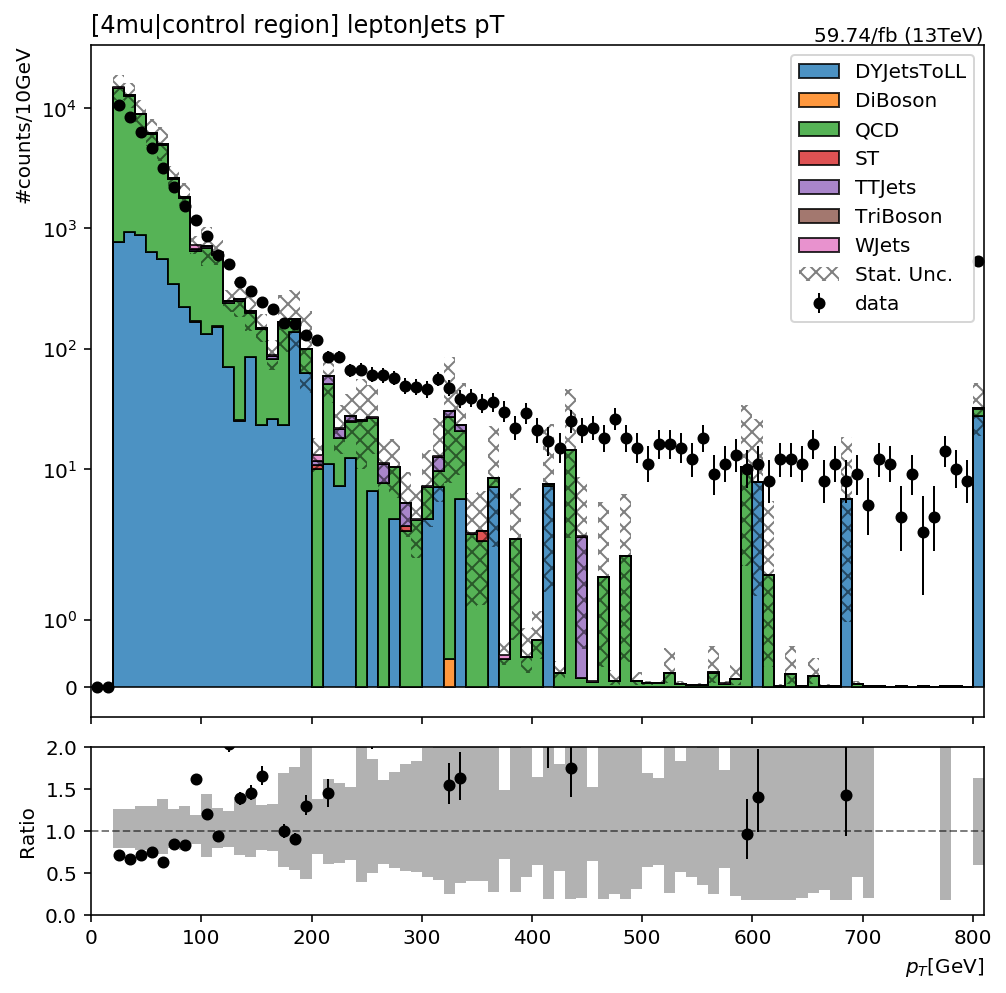

In [24]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['pt_cat'][notdata],
           overlay='cat',
           ax=ax,
           clear=False,
           stack=True,
           overflow='over',
           line_opts=None,
           fill_opts=fill_opts,
           error_opts=error_opts)
hist.plot1d(output['pt_cat']['data'],
           overlay='cat',
           ax=ax,
           overflow='over',
           clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('symlog')
# ax.set_ylim([1, 1e7])
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['pt_cat']['data'].sum('cat'), output['pt_cat'][notdata].sum('cat'),
              ax=rax,
              overflow='over',
              error_opts=data_err_opts,
              denom_fill_opts={},
              guide_opts={},
              unc='num')
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[4mu|control region] leptonJets pT', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

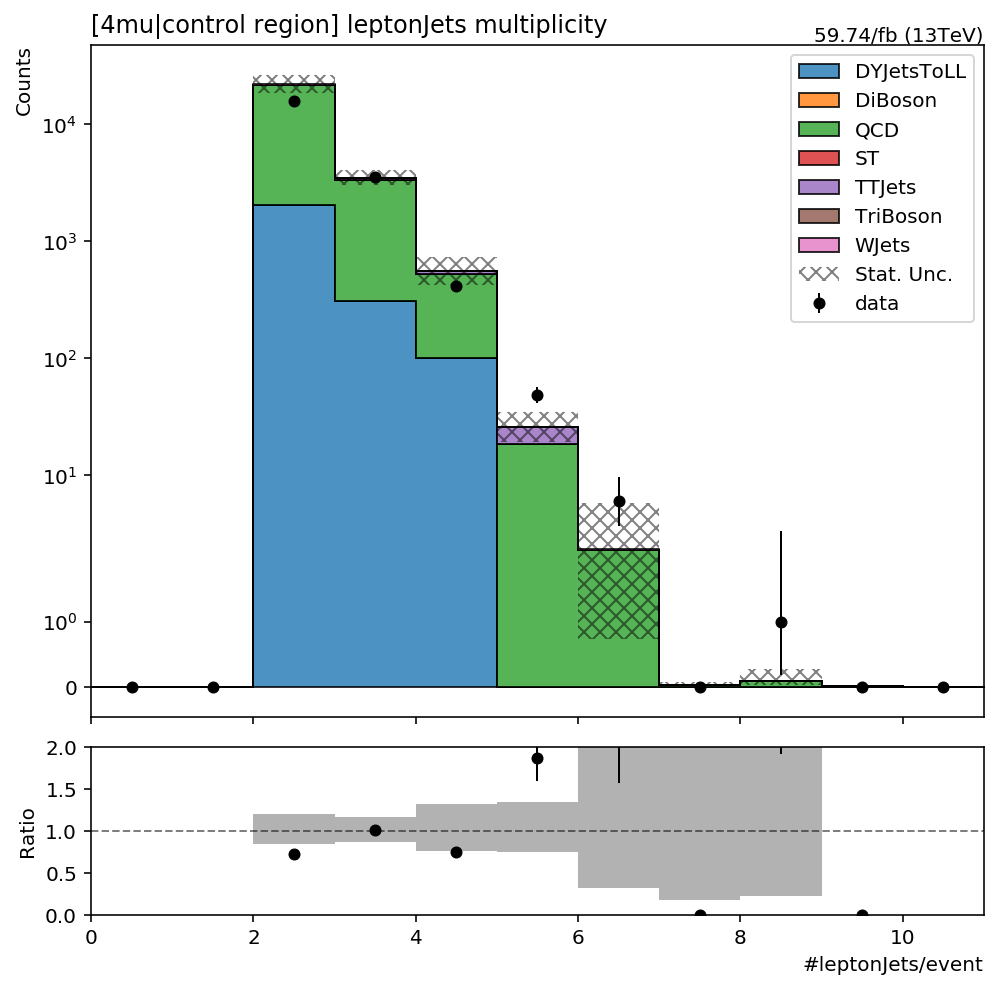

In [25]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['multi_cat'][notdata],
           overlay='cat',
           ax=ax,
           clear=False,
           stack=True,
           overflow='over',
           line_opts=None,
           fill_opts=fill_opts,
           error_opts=error_opts)
hist.plot1d(output['multi_cat']['data'],
           overlay='cat',
           ax=ax,
           overflow='over',
           clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('symlog')
# ax.set_ylim([1, 1e7])
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['multi_cat']['data'].sum('cat'), output['multi_cat'][notdata].sum('cat'),
              ax=rax,
              overflow='over',
              error_opts=data_err_opts,
              denom_fill_opts={},
              guide_opts={},
              unc='num')
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[4mu|control region] leptonJets multiplicity', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

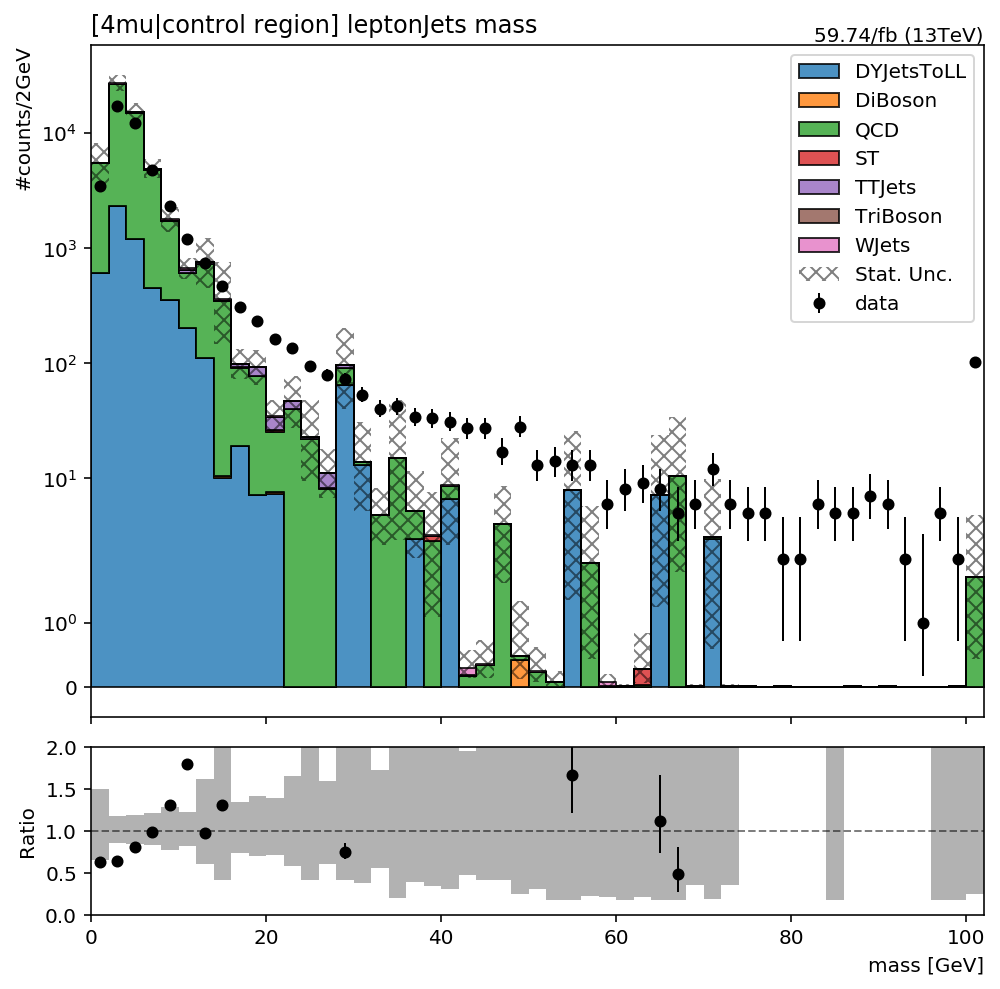

In [26]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['mass_cat'][notdata],
           overlay='cat',
           ax=ax,
           clear=False,
           stack=True,
           overflow='over',
           line_opts=None,
           fill_opts=fill_opts,
           error_opts=error_opts)
hist.plot1d(output['mass_cat']['data'],
           overlay='cat',
           ax=ax,
           overflow='over',
           clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('symlog')
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['mass_cat']['data'].sum('cat'), output['mass_cat'][notdata].sum('cat'),
              ax=rax,
              overflow='over',
              error_opts=data_err_opts,
              denom_fill_opts={},
              guide_opts={},
              unc='num')
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[4mu|control region] leptonJets mass', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

# without any corrections

In [27]:
class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset list')
        multiplicity_axis = hist.Bin("multiplicity", "#leptonJets/event", 10, 0, 10)
        pt_axis = hist.Bin("pt", "$p_T$[GeV]", 80, 0, 800)
        mass_axis = hist.Bin("mass", "mass [GeV]", 50, 0, 100)
        
        self._accumulator = processor.dict_accumulator({
            'multi': hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "pt": hist.Hist("#counts/10GeV", dataset_axis, pt_axis),
            "mass": hist.Hist("#counts/2GeV", dataset_axis, mass_axis),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        dataset = df['dataset']
        if dataset.startswith('TTJets_'): return output # skip TTJets_
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)

        
        if len(dataset)!=1: # => MC
            wgts.add('genw', df['weight'])

#             nvtx = df['trueInteractionNum']
#             pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
#             wgts.add('pileup', pu, puUp, puDown)

#             wnlo = np.ones_like(df.size)
#             if 'TTJets' in dataset or 'WJets' in dataset or 'DYJets' in dataset:
#                 genparticles = JaggedCandidateArray.candidatesfromcounts(
#                     df['gen_p4'],
#                     px=df['gen_p4.fCoordinates.fX'],
#                     py=df['gen_p4.fCoordinates.fY'],
#                     pz=df['gen_p4.fCoordinates.fZ'],
#                     energy=df['gen_p4.fCoordinates.fT'],
#                     pid=df['gen_pid'],
#                 )
#                 gentops = genparticles[np.abs(genparticles.pid)==6]
#                 genws = genparticles[np.abs(genparticles.pid)==24]
#                 genzs = genparticles[np.abs(genparticles.pid)==23]

#                 if 'TTJets' in dataset:
#                     wnlo = np.sqrt(get_ttbar_weight(gentops[0].p4.pt.sum()) * get_ttbar_weight(gentops[1].p4.pt.sum()))
#                 elif 'WJets' in dataset:
#                     wnlo = self.nlo_w(genws[0].p4.pt.sum())
#                 elif 'DYJets' in dataset:
#                     wnlo = self.nlo_z(genzs[0].p4.pt.sum())
#             wgts.add('nlo', wnlo)
            
        weight = wgts.weight()
        ########################
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        twomujets = dileptonjets.ismutype.sum()==2
        wgt = weight[twoleptonjets]
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size==0: return output
        
        leadingLjPair = leptonjetpair[sumpt.argmax()]
        bothmutype = leadingLjPair.i0.ismutype & leadingLjPair.i1.ismutype
        
        controlregion = (np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))<2.5).flatten()
        channelselect = twomujets & bothmutype.flatten()
        leptonjets_ = dileptonjets[controlregion&channelselect]
        if leptonjets_.size==0: return output
        wgt = wgt[controlregion&channelselect]
        wgts= (leptonjets_.pt.ones_like()*wgt).flatten()
        
        output['multi'].fill(dataset=dataset, multiplicity=leptonjets_.counts, weight=wgt)
        output['pt'].fill(dataset=dataset, pt=leptonjets_.pt.flatten(), weight=wgts)
        output['mass'].fill(dataset=dataset, mass=leptonjets_.mass.flatten(), weight=wgts)
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)
        for k in origidentity:
            accumulator[k].scale(bkgscales, axis='dataset') # scale
            accumulator[k+'_cat'] = accumulator[k].group("dataset",
                                                         hist.Cat("cat", "datasets"),
                                                         mapping) # cat grouping
        return accumulator

In [28]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 7285/7285 [09:23<00:00, 12.94items/s]


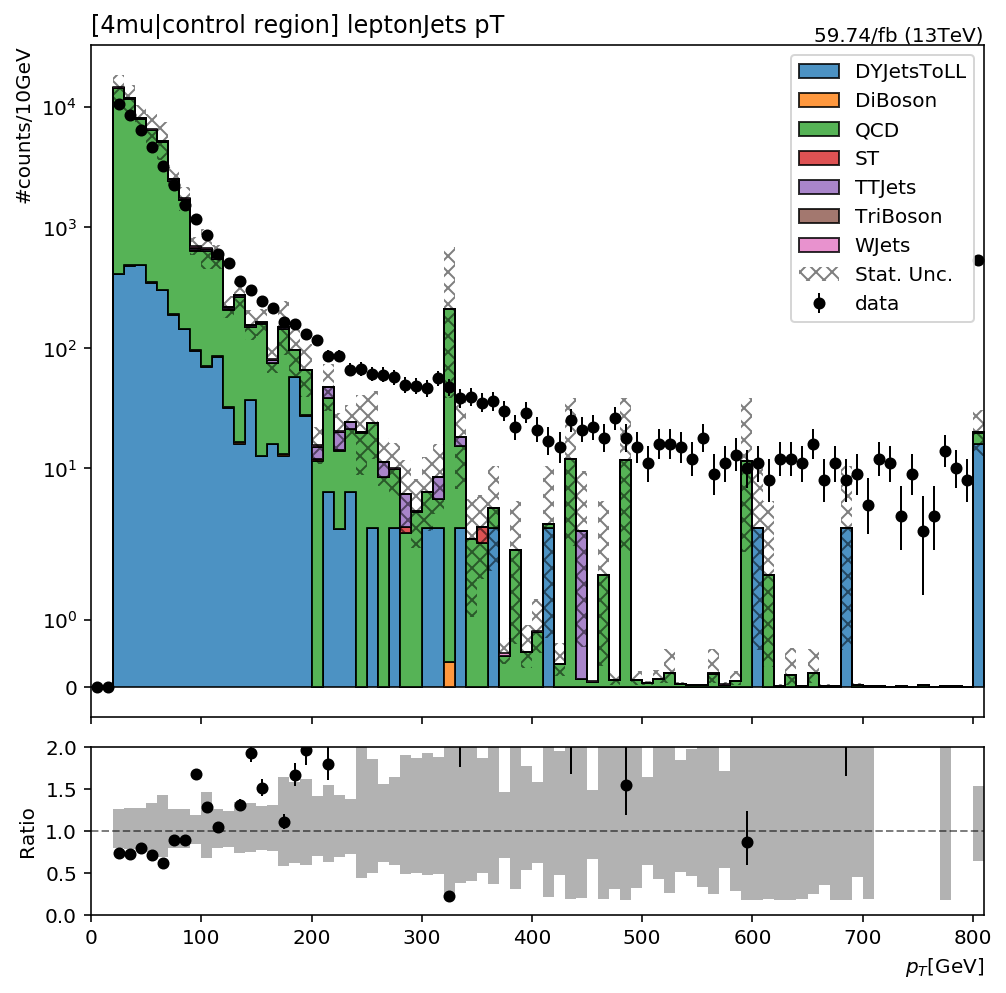

In [29]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['pt_cat'][notdata],
           overlay='cat',
           ax=ax,
           clear=False,
           stack=True,
           overflow='over',
           line_opts=None,
           fill_opts=fill_opts,
           error_opts=error_opts)
hist.plot1d(output['pt_cat']['data'],
           overlay='cat',
           ax=ax,
           overflow='over',
           clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('symlog')
# ax.set_ylim([1, 1e7])
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['pt_cat']['data'].sum('cat'), output['pt_cat'][notdata].sum('cat'),
              ax=rax,
              overflow='over',
              error_opts=data_err_opts,
              denom_fill_opts={},
              guide_opts={},
              unc='num')
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[4mu|control region] leptonJets pT', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

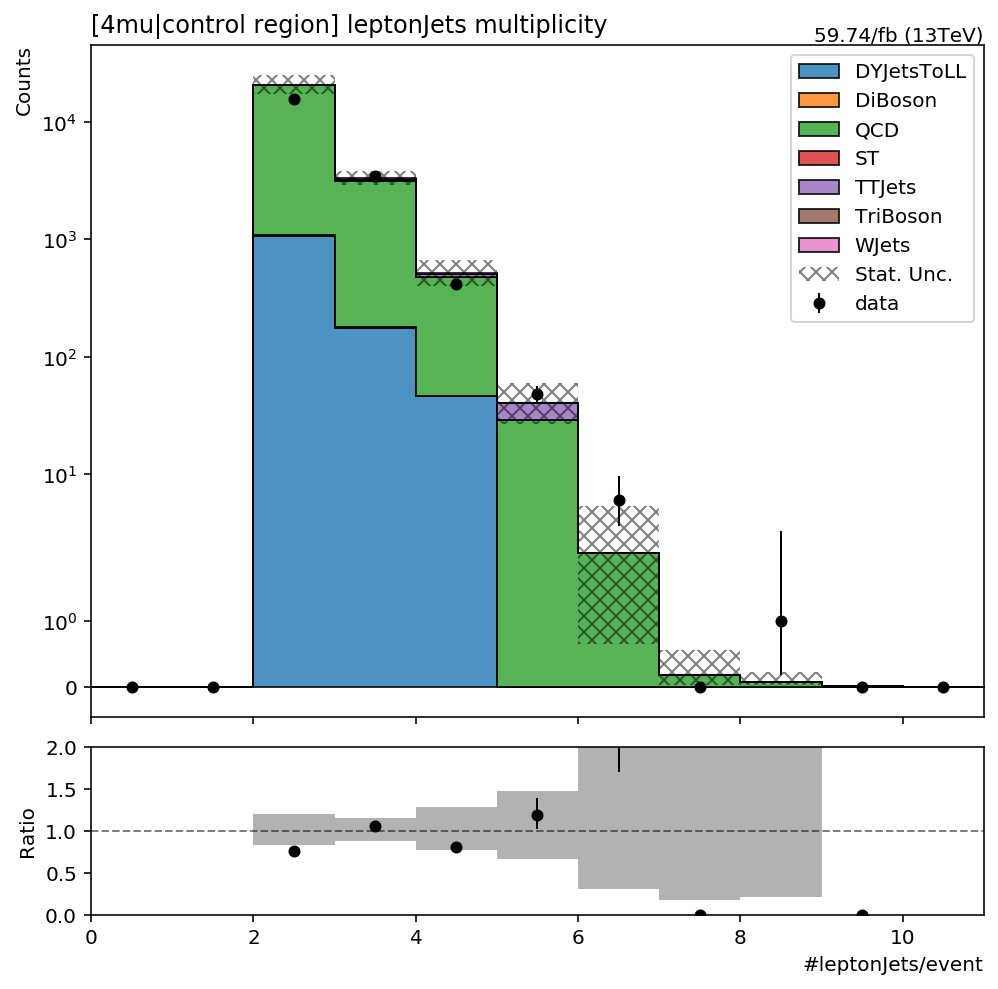

In [30]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['multi_cat'][notdata],
           overlay='cat',
           ax=ax,
           clear=False,
           stack=True,
           overflow='over',
           line_opts=None,
           fill_opts=fill_opts,
           error_opts=error_opts)
hist.plot1d(output['multi_cat']['data'],
           overlay='cat',
           ax=ax,
           overflow='over',
           clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('symlog')
# ax.set_ylim([1, 1e7])
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['multi_cat']['data'].sum('cat'), output['multi_cat'][notdata].sum('cat'),
              ax=rax,
              overflow='over',
              error_opts=data_err_opts,
              denom_fill_opts={},
              guide_opts={},
              unc='num')
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[4mu|control region] leptonJets multiplicity', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

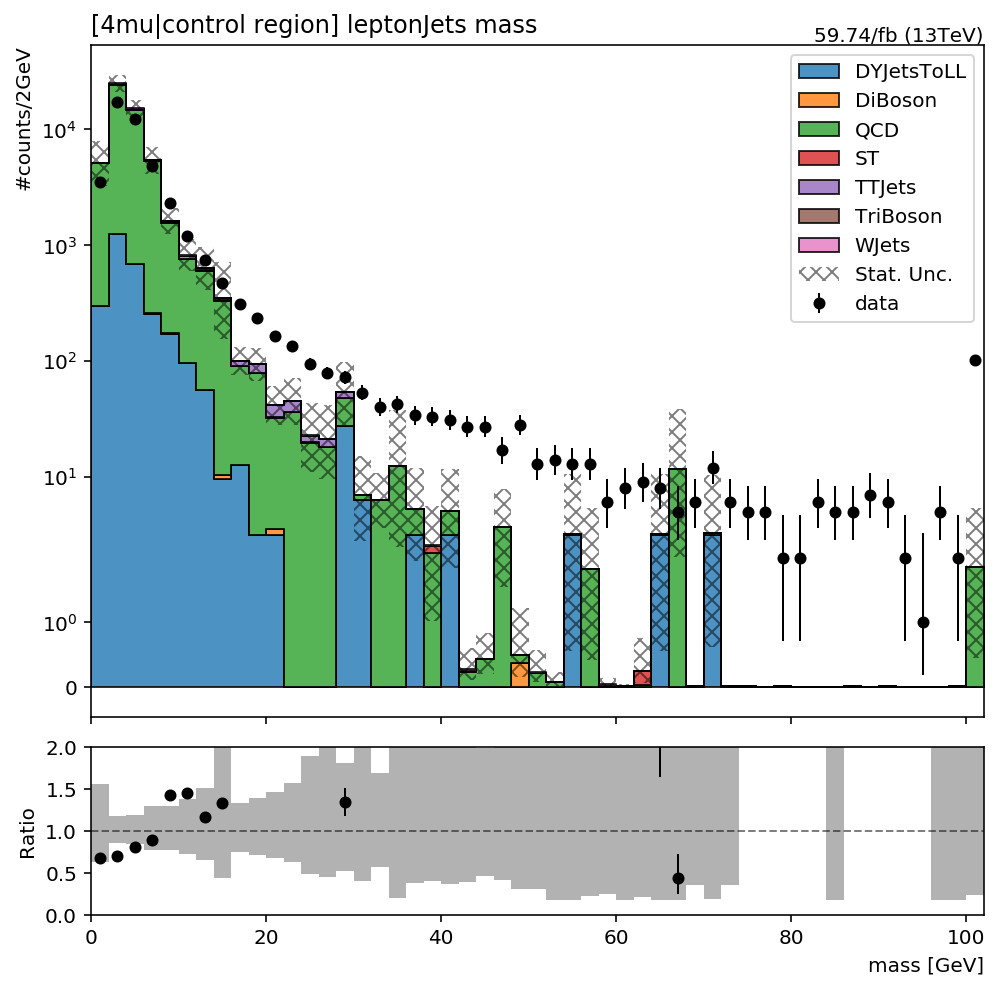

In [31]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['mass_cat'][notdata],
           overlay='cat',
           ax=ax,
           clear=False,
           stack=True,
           overflow='over',
           line_opts=None,
           fill_opts=fill_opts,
           error_opts=error_opts)
hist.plot1d(output['mass_cat']['data'],
           overlay='cat',
           ax=ax,
           overflow='over',
           clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('symlog')
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['mass_cat']['data'].sum('cat'), output['mass_cat'][notdata].sum('cat'),
              ax=rax,
              overflow='over',
              error_opts=data_err_opts,
              denom_fill_opts={},
              guide_opts={},
              unc='num')
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[4mu|control region] leptonJets mass', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

# define mu-type as PFMuon only

In [42]:
class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset list')
        multiplicity_axis = hist.Bin("multiplicity", "#leptonJets/event", 10, 0, 10)
        pt_axis = hist.Bin("pt", "$p_T$[GeV]", 80, 0, 800)
        mass_axis = hist.Bin("mass", "mass [GeV]", 50, 0, 100)
        
        self._accumulator = processor.dict_accumulator({
            'multi': hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "pt": hist.Hist("#counts/10GeV", dataset_axis, pt_axis),
            "mass": hist.Hist("#counts/2GeV", dataset_axis, mass_axis),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        dataset = df['dataset']
        if dataset.startswith('TTJets_'): return output # skip TTJets_
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)

        
        if len(dataset)!=1: # => MC
            wgts.add('genw', df['weight'])

            nvtx = df['trueInteractionNum']
            pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
            wgts.add('pileup', pu, puUp, puDown)

            wnlo = np.ones_like(df.size)
            if 'TTJets' in dataset or 'WJets' in dataset or 'DYJets' in dataset:
                genparticles = JaggedCandidateArray.candidatesfromcounts(
                    df['gen_p4'],
                    px=df['gen_p4.fCoordinates.fX'],
                    py=df['gen_p4.fCoordinates.fY'],
                    pz=df['gen_p4.fCoordinates.fZ'],
                    energy=df['gen_p4.fCoordinates.fT'],
                    pid=df['gen_pid'],
                )
                gentops = genparticles[np.abs(genparticles.pid)==6]
                genws = genparticles[np.abs(genparticles.pid)==24]
                genzs = genparticles[np.abs(genparticles.pid)==23]

                if 'TTJets' in dataset:
                    wnlo = np.sqrt(get_ttbar_weight(gentops[0].p4.pt.sum()) * get_ttbar_weight(gentops[1].p4.pt.sum()))
                elif 'WJets' in dataset:
                    wnlo = self.nlo_w(genws[0].p4.pt.sum())
                elif 'DYJets' in dataset:
                    wnlo = self.nlo_z(genzs[0].p4.pt.sum())
            wgts.add('nlo', wnlo)
            
        weight = wgts.weight()
        ########################
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        nmu = (ljdautype==3).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        twomujets = dileptonjets.ismutype.sum()==2
        wgt = weight[twoleptonjets]
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size==0: return output
        
        leadingLjPair = leptonjetpair[sumpt.argmax()]
        bothmutype = leadingLjPair.i0.ismutype & leadingLjPair.i1.ismutype
        
        controlregion = (np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))<2.5).flatten()
        channelselect = twomujets & bothmutype.flatten()
        leptonjets_ = dileptonjets[controlregion&channelselect]
        if leptonjets_.size==0: return output
        wgt = wgt[controlregion&channelselect]
        wgts= (leptonjets_.pt.ones_like()*wgt).flatten()
        
        output['multi'].fill(dataset=dataset, multiplicity=leptonjets_.counts, weight=wgt)
        output['pt'].fill(dataset=dataset, pt=leptonjets_.pt.flatten(), weight=wgts)
        output['mass'].fill(dataset=dataset, mass=leptonjets_.mass.flatten(), weight=wgts)
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)
        for k in origidentity:
            accumulator[k].scale(bkgscales, axis='dataset') # scale
            accumulator[k+'_cat'] = accumulator[k].group("dataset",
                                                         hist.Cat("cat", "datasets"),
                                                         mapping) # cat grouping
        return accumulator

In [43]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 7285/7285 [10:21<00:00, 11.72items/s]


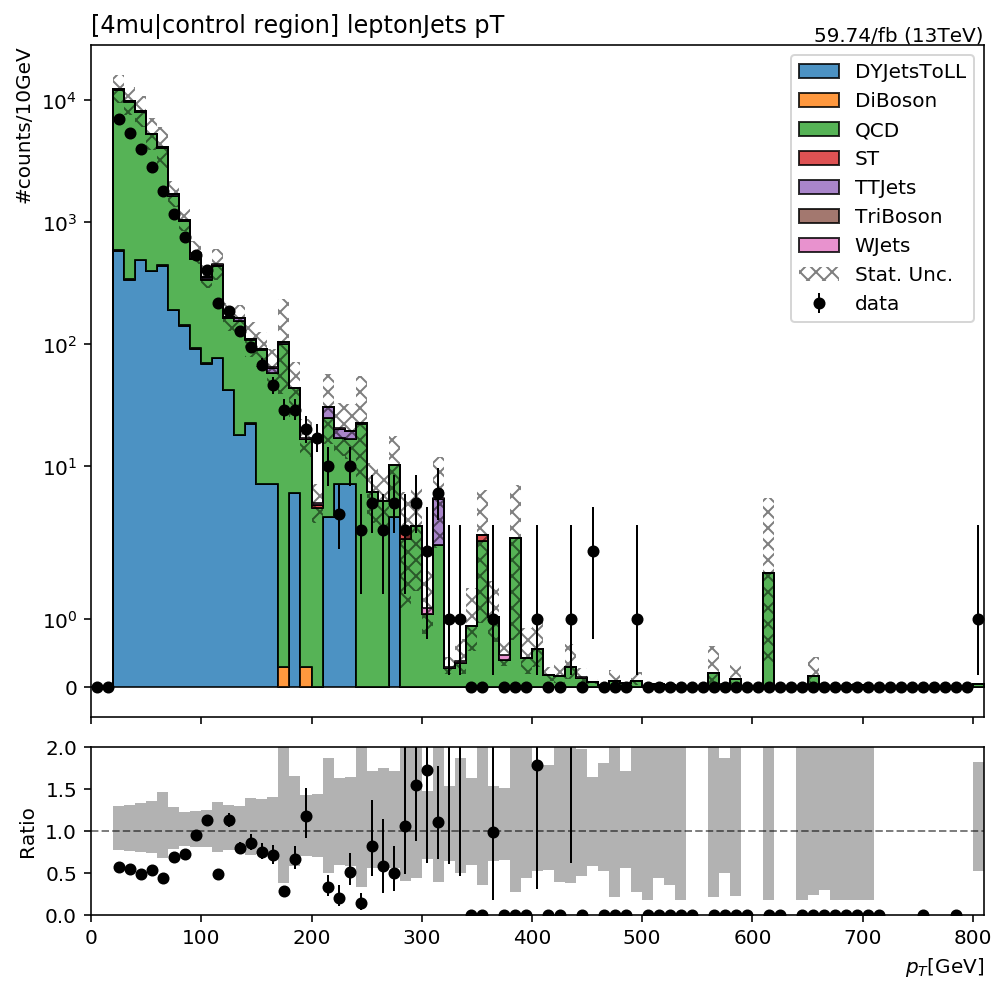

In [44]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['pt_cat'][notdata],
           overlay='cat',
           ax=ax,
           clear=False,
           stack=True,
           overflow='over',
           line_opts=None,
           fill_opts=fill_opts,
           error_opts=error_opts)
hist.plot1d(output['pt_cat']['data'],
           overlay='cat',
           ax=ax,
           overflow='over',
           clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('symlog')
# ax.set_ylim([1, 1e7])
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['pt_cat']['data'].sum('cat'), output['pt_cat'][notdata].sum('cat'),
              ax=rax,
              overflow='over',
              error_opts=data_err_opts,
              denom_fill_opts={},
              guide_opts={},
              unc='num')
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[4mu|control region] leptonJets pT', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

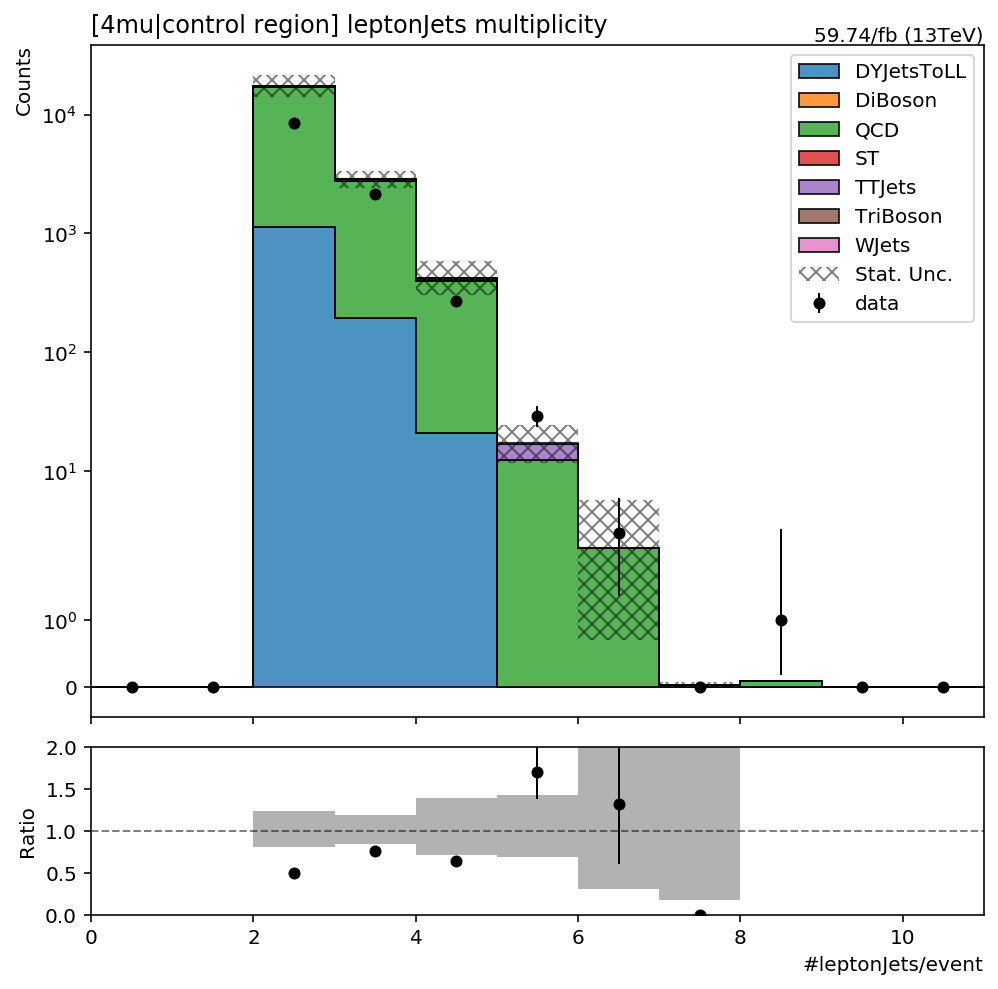

In [45]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['multi_cat'][notdata],
           overlay='cat',
           ax=ax,
           clear=False,
           stack=True,
           overflow='over',
           line_opts=None,
           fill_opts=fill_opts,
           error_opts=error_opts)
hist.plot1d(output['multi_cat']['data'],
           overlay='cat',
           ax=ax,
           overflow='over',
           clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('symlog')
# ax.set_ylim([1, 1e7])
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['multi_cat']['data'].sum('cat'), output['multi_cat'][notdata].sum('cat'),
              ax=rax,
              overflow='over',
              error_opts=data_err_opts,
              denom_fill_opts={},
              guide_opts={},
              unc='num')
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[4mu|control region] leptonJets multiplicity', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

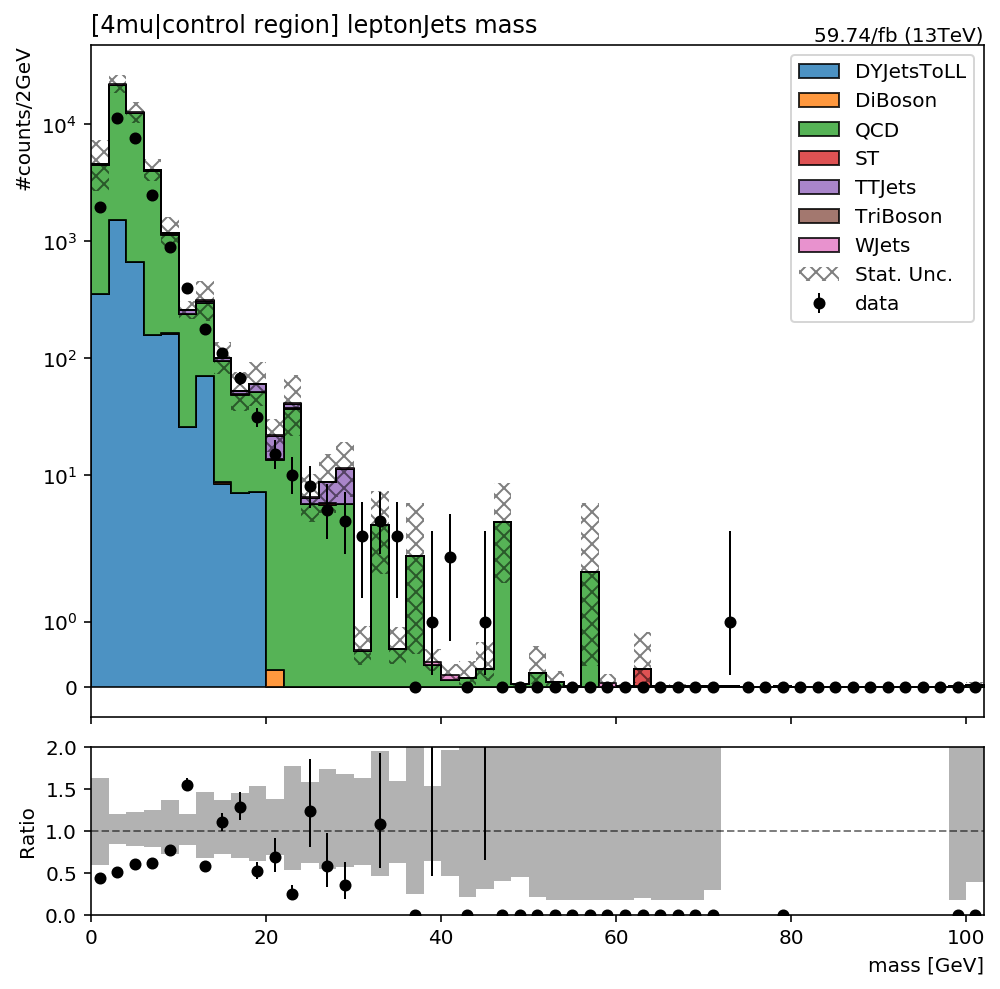

In [46]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['mass_cat'][notdata],
           overlay='cat',
           ax=ax,
           clear=False,
           stack=True,
           overflow='over',
           line_opts=None,
           fill_opts=fill_opts,
           error_opts=error_opts)
hist.plot1d(output['mass_cat']['data'],
           overlay='cat',
           ax=ax,
           overflow='over',
           clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('symlog')
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['mass_cat']['data'].sum('cat'), output['mass_cat'][notdata].sum('cat'),
              ax=rax,
              overflow='over',
              error_opts=data_err_opts,
              denom_fill_opts={},
              guide_opts={},
              unc='num')
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[4mu|control region] leptonJets mass', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

# just the leading two muon-type leptonjets

In [47]:
class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset list')
        multiplicity_axis = hist.Bin("multiplicity", "#leptonJets/event", 10, 0, 10)
        pt_axis = hist.Bin("pt", "$p_T$[GeV]", 80, 0, 800)
        mass_axis = hist.Bin("mass", "mass [GeV]", 50, 0, 100)
        
        self._accumulator = processor.dict_accumulator({
            'multi': hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "pt": hist.Hist("#counts/10GeV", dataset_axis, pt_axis),
            "mass": hist.Hist("#counts/2GeV", dataset_axis, mass_axis),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        dataset = df['dataset']
        if dataset.startswith('TTJets_'): return output # skip TTJets_
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)

        
        if len(dataset)!=1: # => MC
            wgts.add('genw', df['weight'])

            nvtx = df['trueInteractionNum']
            pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
            wgts.add('pileup', pu, puUp, puDown)

            wnlo = np.ones_like(df.size)
            if 'TTJets' in dataset or 'WJets' in dataset or 'DYJets' in dataset:
                genparticles = JaggedCandidateArray.candidatesfromcounts(
                    df['gen_p4'],
                    px=df['gen_p4.fCoordinates.fX'],
                    py=df['gen_p4.fCoordinates.fY'],
                    pz=df['gen_p4.fCoordinates.fZ'],
                    energy=df['gen_p4.fCoordinates.fT'],
                    pid=df['gen_pid'],
                )
                gentops = genparticles[np.abs(genparticles.pid)==6]
                genws = genparticles[np.abs(genparticles.pid)==24]
                genzs = genparticles[np.abs(genparticles.pid)==23]

                if 'TTJets' in dataset:
                    wnlo = np.sqrt(get_ttbar_weight(gentops[0].p4.pt.sum()) * get_ttbar_weight(gentops[1].p4.pt.sum()))
                elif 'WJets' in dataset:
                    wnlo = self.nlo_w(genws[0].p4.pt.sum())
                elif 'DYJets' in dataset:
                    wnlo = self.nlo_z(genzs[0].p4.pt.sum())
            wgts.add('nlo', wnlo)
            
        weight = wgts.weight()
        ########################
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        nmu = (ljdautype==3).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        twomujets = dileptonjets.ismutype.sum()==2
        wgt = weight[twoleptonjets]
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size==0: return output
        
        leadingLjPair = leptonjetpair[sumpt.argmax()]
        bothmutype = leadingLjPair.i0.ismutype & leadingLjPair.i1.ismutype
        
        controlregion = (np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))<2.5).flatten()
        channelselect = twomujets & bothmutype.flatten()
        leptonjets_ = dileptonjets[controlregion&channelselect]
        if leptonjets_.size==0: return output
        wgt = wgt[controlregion&channelselect]
        
        leadingtwo = leptonjets_[leptonjets_.pt.argsort()[:, :2]]
        wgts= (leadingtwo.pt.ones_like()*wgt).flatten()
        
        output['multi'].fill(dataset=dataset, multiplicity=leptonjets_.counts, weight=wgt)
        output['pt'].fill(dataset=dataset, pt=leadingtwo.pt.flatten(), weight=wgts)
        output['mass'].fill(dataset=dataset, mass=leadingtwo.mass.flatten(), weight=wgts)
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)
        for k in origidentity:
            accumulator[k].scale(bkgscales, axis='dataset') # scale
            accumulator[k+'_cat'] = accumulator[k].group("dataset",
                                                         hist.Cat("cat", "datasets"),
                                                         mapping) # cat grouping
        return accumulator

In [48]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 7285/7285 [10:34<00:00, 11.49items/s]


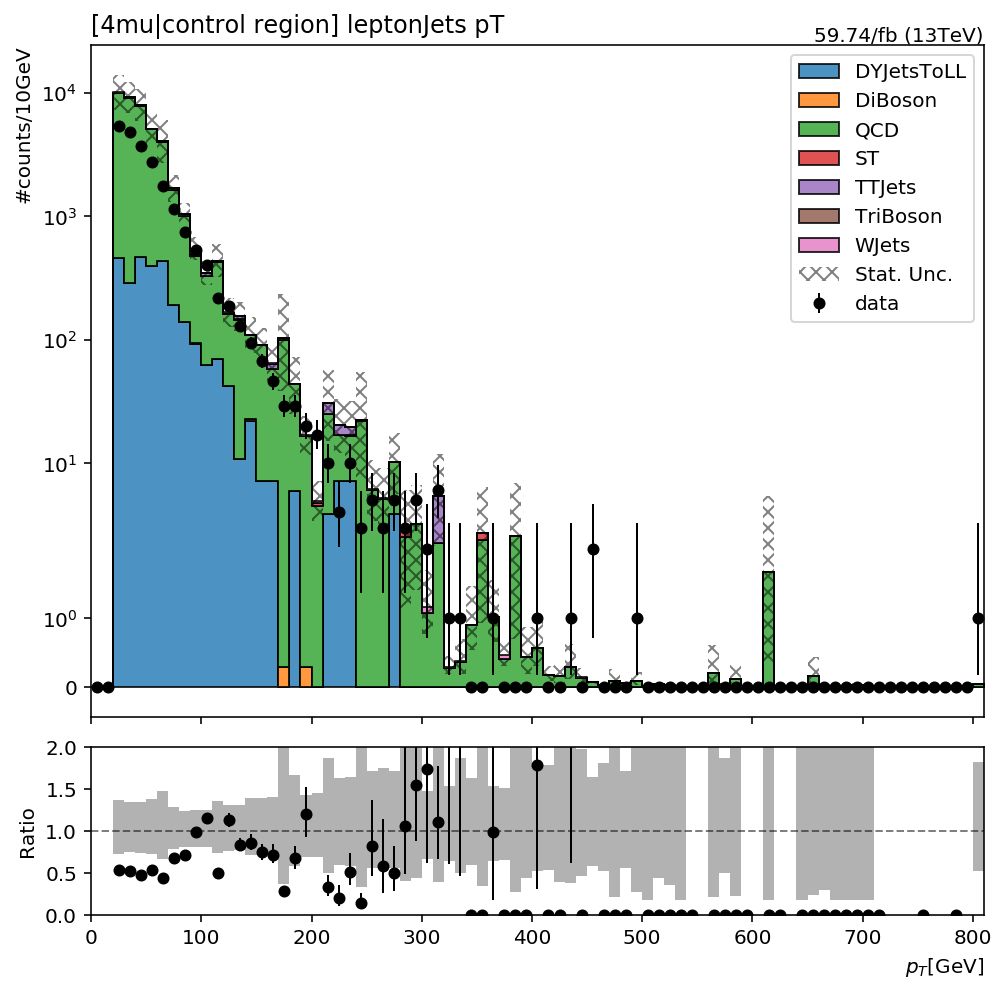

In [49]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['pt_cat'][notdata],
           overlay='cat',
           ax=ax,
           clear=False,
           stack=True,
           overflow='over',
           line_opts=None,
           fill_opts=fill_opts,
           error_opts=error_opts)
hist.plot1d(output['pt_cat']['data'],
           overlay='cat',
           ax=ax,
           overflow='over',
           clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('symlog')
# ax.set_ylim([1, 1e7])
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['pt_cat']['data'].sum('cat'), output['pt_cat'][notdata].sum('cat'),
              ax=rax,
              overflow='over',
              error_opts=data_err_opts,
              denom_fill_opts={},
              guide_opts={},
              unc='num')
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[4mu|control region] leptonJets pT', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

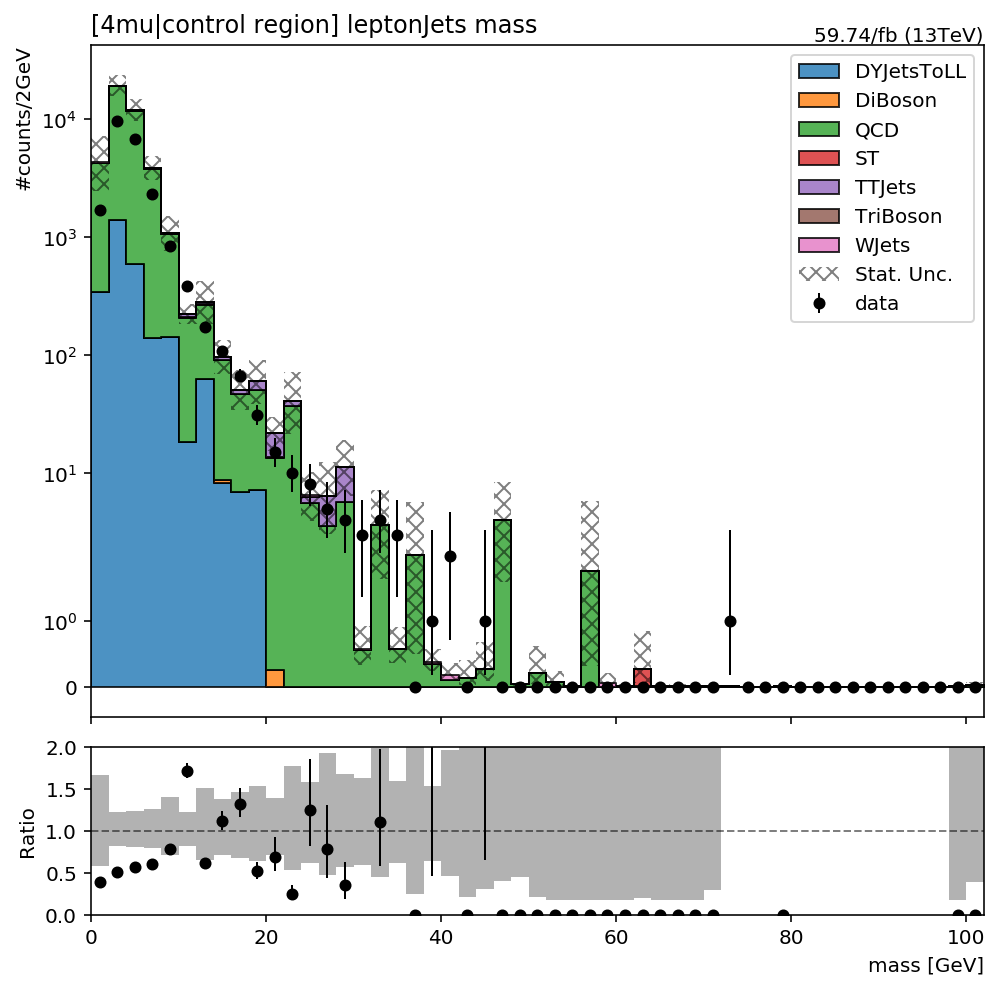

In [50]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['mass_cat'][notdata],
           overlay='cat',
           ax=ax,
           clear=False,
           stack=True,
           overflow='over',
           line_opts=None,
           fill_opts=fill_opts,
           error_opts=error_opts)
hist.plot1d(output['mass_cat']['data'],
           overlay='cat',
           ax=ax,
           overflow='over',
           clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('symlog')
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['mass_cat']['data'].sum('cat'), output['mass_cat'][notdata].sum('cat'),
              ax=rax,
              overflow='over',
              error_opts=data_err_opts,
              denom_fill_opts={},
              guide_opts={},
              unc='num')
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[4mu|control region] leptonJets mass', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

# split leading and subleading leptonjets

In [8]:
ptbinning = np.concatenate([np.arange(0, 100, 10),
                            np.arange(100, 200, 20),
                            np.arange(200, 500, 50),
                            np.arange(500, 800, 100)])
massbinning = np.concatenate([np.arange(0, 20, 5),
                             np.arange(20, 40, 10),
                             np.arange(40, 100, 50)])

In [14]:
class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset list')
        multiplicity_axis = hist.Bin("multiplicity", "#leptonJets/event", 10, 0, 10)
        pt_axis = hist.Bin("pt", "$p_T$[GeV]", ptbinning)
        mass_axis = hist.Bin("mass", "mass [GeV]", massbinning)
        
        self._accumulator = processor.dict_accumulator({
            'multi': hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "leadpt": hist.Hist("Counts", dataset_axis, pt_axis),
            "subleadpt": hist.Hist("Counts", dataset_axis, pt_axis),
            "leadmass": hist.Hist("Counts", dataset_axis, mass_axis),
            "subleadmass": hist.Hist("Counts", dataset_axis, mass_axis),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        dataset = df['dataset']
        if dataset.startswith('TTJets_'): return output # skip TTJets_
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)

        
        if len(dataset)!=1: # => MC
            wgts.add('genw', df['weight'])

            nvtx = df['trueInteractionNum']
            pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
            wgts.add('pileup', pu, puUp, puDown)

            wnlo = np.ones_like(df.size)
            if 'TTJets' in dataset or 'WJets' in dataset or 'DYJets' in dataset:
                genparticles = JaggedCandidateArray.candidatesfromcounts(
                    df['gen_p4'],
                    px=df['gen_p4.fCoordinates.fX'],
                    py=df['gen_p4.fCoordinates.fY'],
                    pz=df['gen_p4.fCoordinates.fZ'],
                    energy=df['gen_p4.fCoordinates.fT'],
                    pid=df['gen_pid'],
                )
                gentops = genparticles[np.abs(genparticles.pid)==6]
                genws = genparticles[np.abs(genparticles.pid)==24]
                genzs = genparticles[np.abs(genparticles.pid)==23]

                if 'TTJets' in dataset:
                    wnlo = np.sqrt(get_ttbar_weight(gentops[0].p4.pt.sum()) * get_ttbar_weight(gentops[1].p4.pt.sum()))
                elif 'WJets' in dataset:
                    wnlo = self.nlo_w(genws[0].p4.pt.sum())
                elif 'DYJets' in dataset:
                    wnlo = self.nlo_z(genzs[0].p4.pt.sum())
            wgts.add('nlo', wnlo)
            
        weight = wgts.weight()
        ########################
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        nmu = (ljdautype==3).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        twomujets = dileptonjets.ismutype.sum()==2
        wgt = weight[twoleptonjets]
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size==0: return output
        
        leadingLjPair = leptonjetpair[sumpt.argmax()]
        bothmutype = leadingLjPair.i0.ismutype & leadingLjPair.i1.ismutype
        
        controlregion = (np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))<2.5).flatten()
        channelselect = twomujets & bothmutype.flatten()
        leptonjets_ = dileptonjets[controlregion&channelselect]
        if leptonjets_.size==0: return output
        wgt = wgt[controlregion&channelselect]
        
#         leadingtwo = leptonjets_[leptonjets_.pt.argsort()[:, :2]]
        leading = leptonjets_[leptonjets_.pt.argmax()]
        subleading = leptonjets_[leptonjets_.pt.argsort()[:, 1:2]]
#         wgts= (leadingtwo.pt.ones_like()*wgt).flatten()

        output['multi'].fill(dataset=dataset, multiplicity=leptonjets_.counts, weight=wgt)
#         output['pt'].fill(dataset=dataset, pt=leadingtwo.pt.flatten(), weight=wgts)
        output['leadpt'].fill(dataset=dataset, pt=leading.pt.flatten(), weight=wgt)
        output['subleadpt'].fill(dataset=dataset, pt=subleading.pt.flatten(), weight=wgt)
#         output['mass'].fill(dataset=dataset, mass=leadingtwo.mass.flatten(), weight=wgts)
        output['leadmass'].fill(dataset=dataset, mass=leading.mass.flatten(), weight=wgt)
        output['subleadmass'].fill(dataset=dataset, mass=subleading.mass.flatten(), weight=wgt)
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)
        for k in origidentity:
            accumulator[k].scale(bkgscales, axis='dataset') # scale
            accumulator[k+'_cat'] = accumulator[k].group("dataset",
                                                         hist.Cat("cat", "datasets"),
                                                         mapping) # cat grouping
        return accumulator

In [16]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 7285/7285 [09:12<00:00, 13.19items/s]


In [29]:
def makeplot(plotvar, title, overflow='over'):
    fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), sharex=True,
                                  gridspec_kw={"height_ratios": (4, 1)},)
    fig.subplots_adjust(hspace=.07)

    hist.plot1d(output[plotvar][notdata],
               overlay='cat',
               ax=ax,
               clear=False,
               stack=True,
               overflow=overflow,
               line_opts=None,
               fill_opts=fill_opts,
               error_opts=error_opts)
    hist.plot1d(output[plotvar]['data'],
               overlay='cat',
               ax=ax,
               overflow=overflow,
               clear=False,
               error_opts=data_err_opts)
    ax.autoscale(axis='x', tight=True)
    ax.set_yscale('symlog')
    ax.set_xlabel(None)
    leg=ax.legend()

    hist.plotratio(output[plotvar]['data'].sum('cat'),
                   output[plotvar][notdata].sum('cat'),
                   ax=rax,
                   overflow=overflow,
                   error_opts=data_err_opts,
                   denom_fill_opts={},
                   guide_opts={},
                   unc='num')
    rax.set_ylabel('Ratio')
    rax.set_ylim(0,2)

    rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.set_title(f'[4mu|control region] {title}', x=0.0, ha="left")
    ax.text(1,1,'59.74/fb (13TeV)',
            ha='right', va='bottom', transform=ax.transAxes)

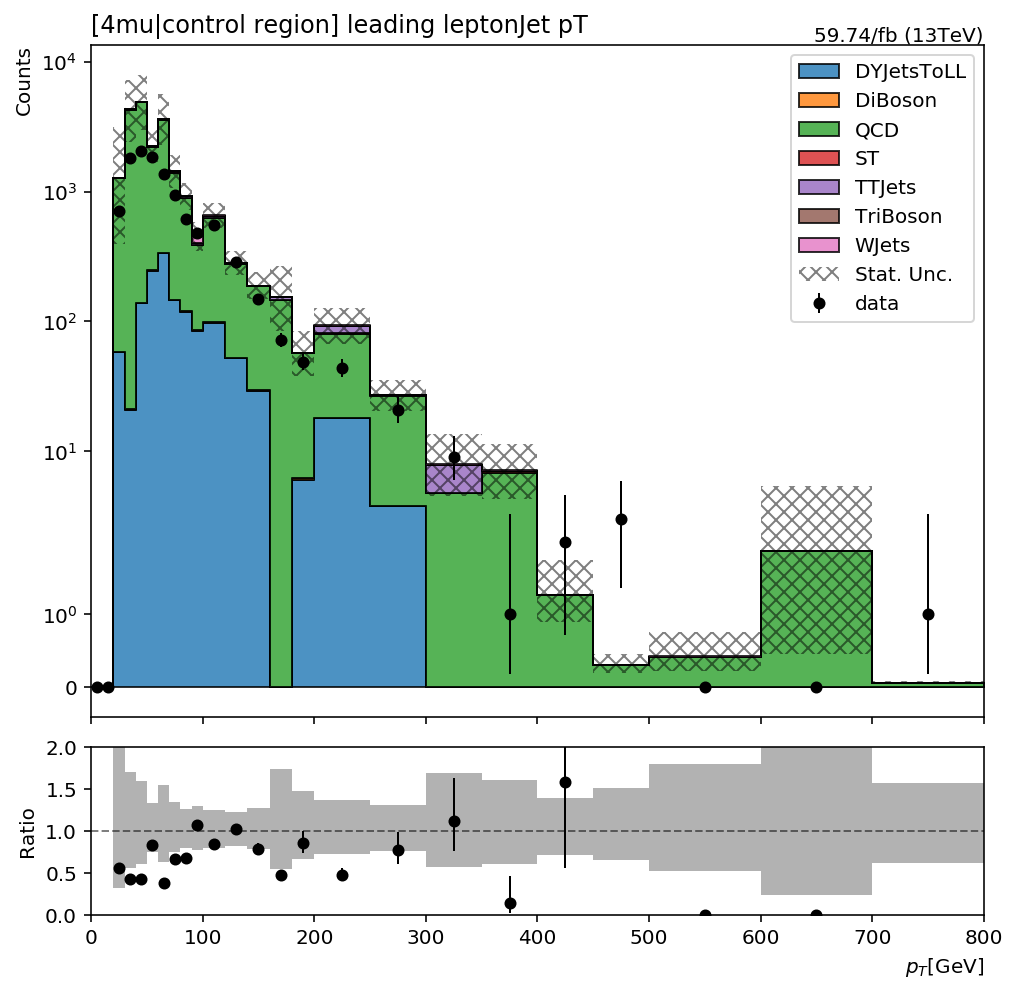

In [22]:
makeplot('leadpt_cat', 'leading leptonJet pT');

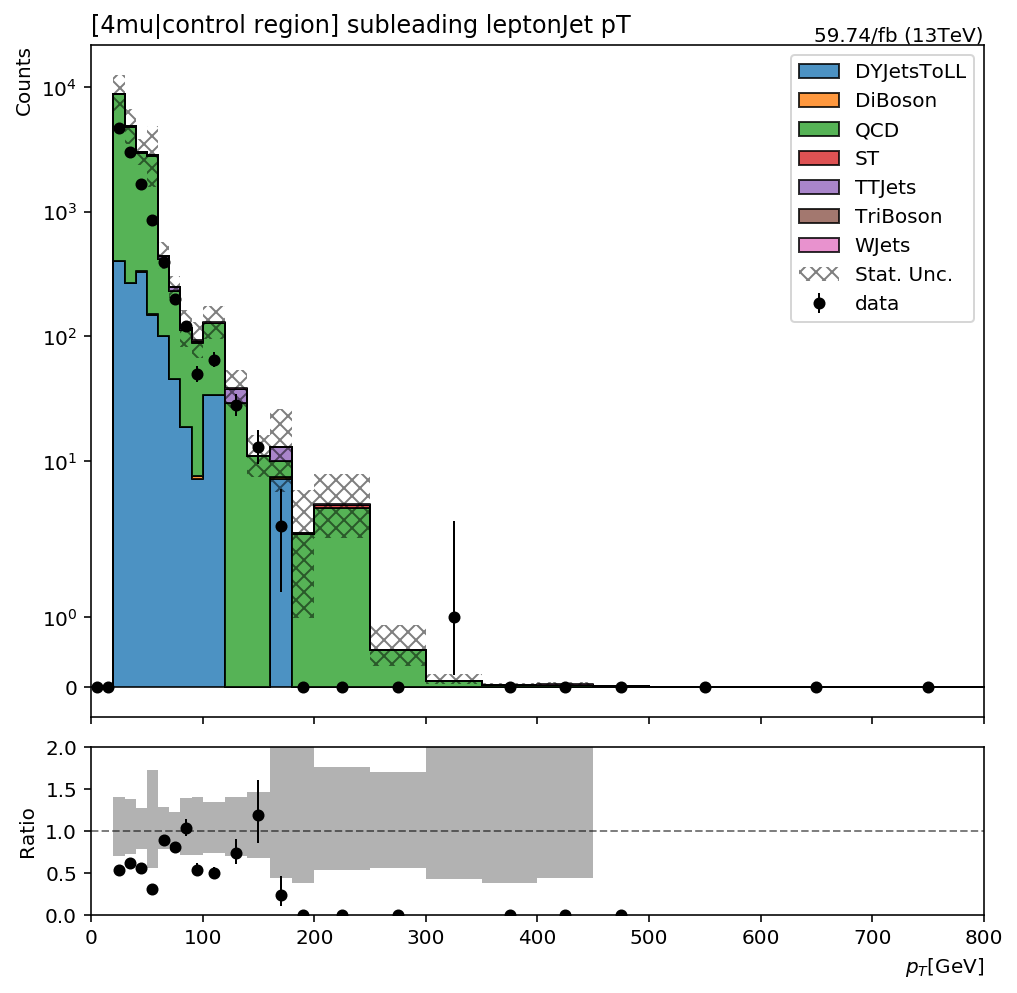

In [23]:
makeplot('subleadpt_cat', 'subleading leptonJet pT');

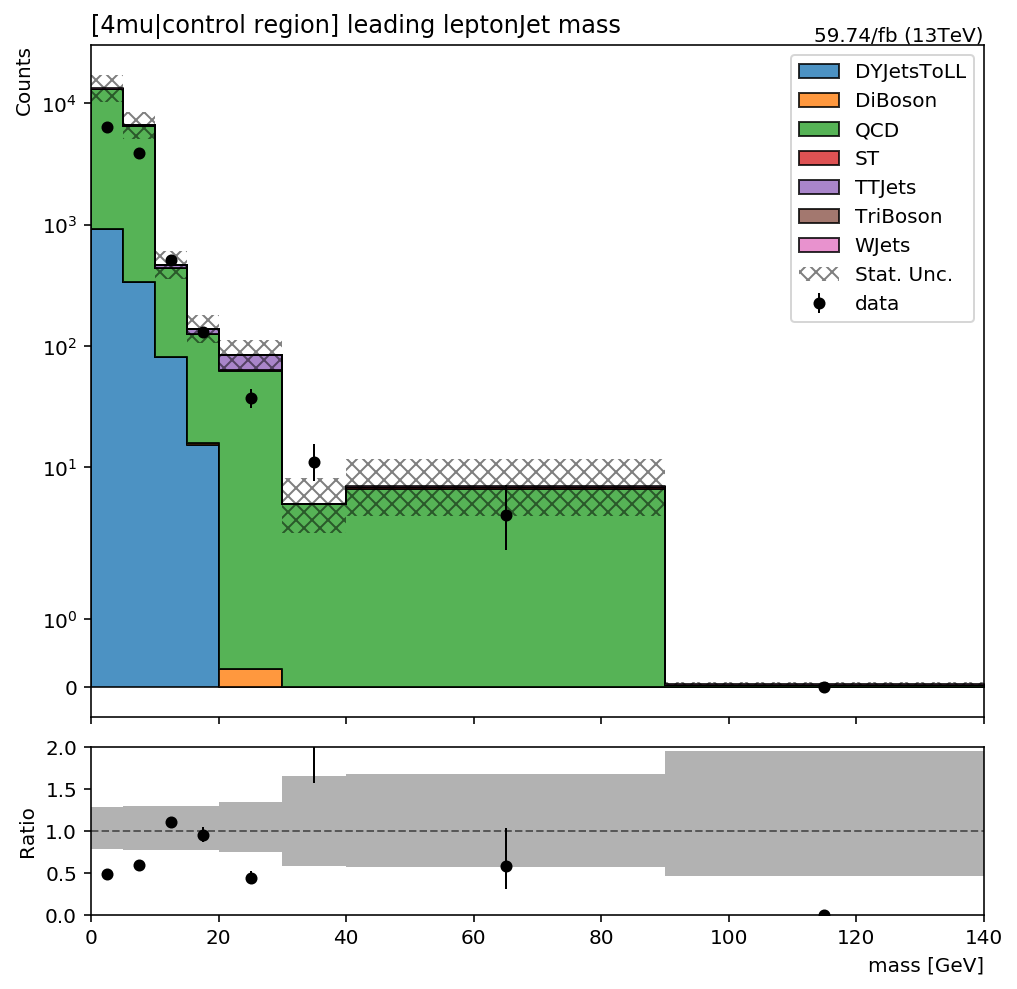

In [24]:
makeplot('leadmass_cat', 'leading leptonJet mass');

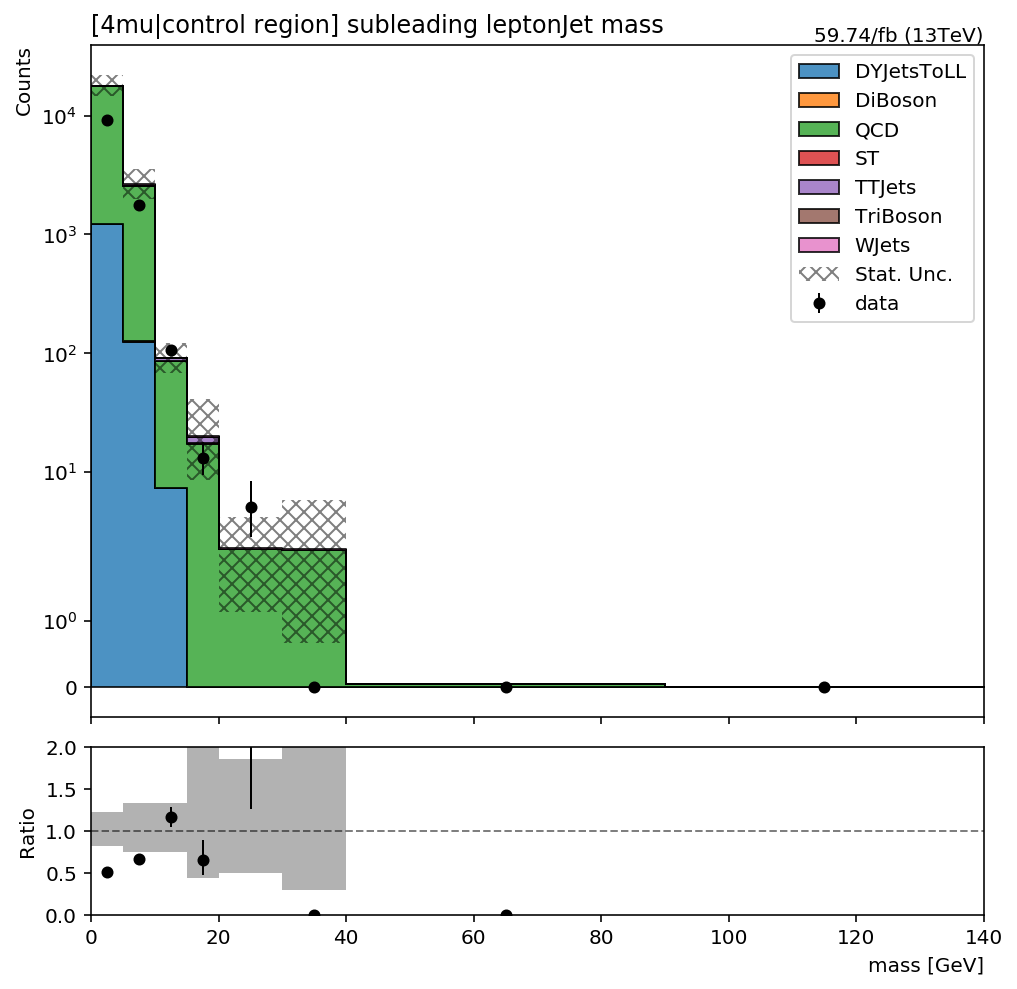

In [25]:
makeplot('subleadmass_cat', 'subleading leptonJet mass');

# BDT variables

In [27]:
class LeptonJetsProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'Control region')
        pt_axis       = hist.Bin("pt", "pT [GeV]", ptbinning)
        eta_axis      = hist.Bin("eta", 'eta', 50, -2.4, 2.4)
        nef_axis      = hist.Bin("nef", "neutral energy fraction", 50, 0, 1.001)
        maxd0_axis    = hist.Bin("maxd0", 'track max |d0|', 50, 0, 0.5)
        mind0_axis    = hist.Bin("mind0", 'track min |d0|', 50, 0, 0.5)
        tkiso_axis    = hist.Bin('tkiso', 'track isolation', 50, 0, 1)
        pfiso_axis    = hist.Bin("pfiso", "PFCands isolation", 50, 0, 1)
        spreadpt_axis = hist.Bin("spreadpt", "spreadpt", 50, 0, 1)
        spreaddr_axis = hist.Bin("spreaddr", "spreaddr", 50, 0, 0.1)
        lambda_axis   = hist.Bin('lamb', 'jet sub - lambda', 50, -8, 0)
        epsilon_axis  = hist.Bin('epsi', 'jet sub - epsilon', 50, 0, 0.25)
        ecfe1_axis    = hist.Bin('ecfe1', 'energy correlation function - e1', 50, 0, 200)
        ecfe2_axis    = hist.Bin('ecfe2', 'energy correlation function - e2', 50, 0, 500)
        ecfe3_axis    = hist.Bin('ecfe3', 'energy correlation function - e3', 50, 0, 300)
        mva_axis      = hist.Bin('mva', 'BDT value', 50, -10, 10)
        
        self._accumulator = processor.dict_accumulator({
            'pt': hist.Hist("#counts/16GeV", dataset_axis, pt_axis),
            "eta": hist.Hist("#counts/0.096", dataset_axis, eta_axis),
            "nef": hist.Hist("#counts/0.02", dataset_axis, nef_axis),
            "maxd0": hist.Hist("#counts/0.01cm", dataset_axis, maxd0_axis),
            "mind0": hist.Hist("#counts/0.01cm", dataset_axis, mind0_axis),
            "tkiso": hist.Hist("#counts/0.02", dataset_axis, tkiso_axis),
            "pfiso": hist.Hist("#counts/0.02", dataset_axis, pfiso_axis),
            "spreadpt": hist.Hist("#counts/0.02", dataset_axis, spreadpt_axis),
            "spreaddr": hist.Hist("#counts/0.002", dataset_axis, spreaddr_axis),
            "lamb": hist.Hist("#counts/0.16", dataset_axis, lambda_axis),
            "epsi": hist.Hist("#counts/0.005", dataset_axis, epsilon_axis),
            "ecfe1": hist.Hist("#counts/4", dataset_axis, ecfe1_axis),
            "ecfe2": hist.Hist("#counts/10", dataset_axis, ecfe2_axis),
            "ecfe3": hist.Hist("#counts/6", dataset_axis, ecfe3_axis),
            "mva": hist.Hist("#counts/0.4", dataset_axis, mva_axis),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')

    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        dataset = df['dataset']
        if dataset.startswith('TTJets_'): return output # skip TTJets_
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)
        
        if len(dataset)!=1:
            wgts.add('genw', df['weight'])

            nvtx = df['trueInteractionNum']
            pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
            wgts.add('pileup', pu, puUp, puDown)

            wnlo = np.ones_like(df.size)
            if 'TTJets' in dataset or 'WJets' in dataset or 'DYJets' in dataset:
                genparticles = JaggedCandidateArray.candidatesfromcounts(
                    df['gen_p4'],
                    px=df['gen_p4.fCoordinates.fX'],
                    py=df['gen_p4.fCoordinates.fY'],
                    pz=df['gen_p4.fCoordinates.fZ'],
                    energy=df['gen_p4.fCoordinates.fT'],
                    pid=df['gen_pid'],
                )
                gentops = genparticles[np.abs(genparticles.pid)==6]
                genws = genparticles[np.abs(genparticles.pid)==24]
                genzs = genparticles[np.abs(genparticles.pid)==23]

                if 'TTJets' in dataset:
                    wnlo = np.sqrt(get_ttbar_weight(gentops[0].p4.pt.sum()) * get_ttbar_weight(gentops[1].p4.pt.sum()))
                elif 'WJets' in dataset:
                    wnlo = self.nlo_w(genws[0].p4.pt.sum())
                elif 'DYJets' in dataset:
                    wnlo = self.nlo_z(genzs[0].p4.pt.sum())
            wgts.add('nlo', wnlo)
            
        weight = wgts.weight()
        ########################
        
#         absd0 = np.abs(NestNestObjArrayToJagged(df['pfjet_pfcand_tkD0'])).fillna(0)
        absd0 = np.abs(awkward.fromiter(df['pfjet_pfcand_tkD0'])).fillna(0)
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
            nef=(df['pfjet_neutralEmE']+df['pfjet_neutralHadronE'])/df['pfjet_p4.fCoordinates.fT'],
            maxd0=absd0.max().content,
            mind0=absd0.min().content,
            tkiso=df['pfjet_tkIsolation05'],
            pfiso=df['pfjet_pfIsolation05'],
            spreadpt=df['pfjet_ptDistribution'],
            spreaddr=df['pfjet_dRSpread'],
            lamb=df['pfjet_subjet_lambda'],
            epsi=df['pfjet_subjet_epsilon'],
            ecf1=df['pfjet_subjet_ecf1'],
            ecf2=df['pfjet_subjet_ecf2'],
            ecf3=df['pfjet_subjet_ecf3'],
            mva=df['pfjet_mva'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        nmu = (ljdautype==3).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        twomujets = dileptonjets.ismutype.sum()==2
        wgt = weight[twoleptonjets]
        
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size==0: return output
        
        leadingLjPair = leptonjetpair[sumpt.argmax()]
        bothmutype = leadingLjPair.i0.ismutype & leadingLjPair.i1.ismutype
        
        controlregion = (np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))<2.5).flatten()
        channelselect = twomujets & bothmutype.flatten()
        leptonjets_ = dileptonjets[controlregion&channelselect]
        wgt = wgt[controlregion&channelselect]
        wgts= (leptonjets_.pt.ones_like()*wgt).flatten()

        output['pt'].fill(dataset=dataset, pt=leptonjets_.pt.flatten(), weight=wgts)
        output['eta'].fill(dataset=dataset, eta=leptonjets_.eta.flatten(), weight=wgts)
        output['nef'].fill(dataset=dataset, nef=leptonjets_.nef.flatten(), weight=wgts)
        output['maxd0'].fill(dataset=dataset, maxd0=leptonjets_.maxd0.flatten(), weight=wgts)
        output['mind0'].fill(dataset=dataset, mind0=leptonjets_.mind0.flatten(), weight=wgts)
        output['tkiso'].fill(dataset=dataset, tkiso=leptonjets_.tkiso.flatten(), weight=wgts)
        output['pfiso'].fill(dataset=dataset, pfiso=leptonjets_.pfiso.flatten(), weight=wgts)
        output['spreadpt'].fill(dataset=dataset, spreadpt=leptonjets_.spreadpt.flatten(), weight=wgts)
        output['spreaddr'].fill(dataset=dataset, spreaddr=leptonjets_.spreaddr.flatten(), weight=wgts)
        output['lamb'].fill(dataset=dataset, lamb=leptonjets_.lamb.flatten(), weight=wgts)
        output['epsi'].fill(dataset=dataset, epsi=leptonjets_.epsi.flatten(), weight=wgts)
        output['ecfe1'].fill(dataset=dataset, ecfe1=leptonjets_.ecf1.flatten(), weight=wgts)
        output['ecfe2'].fill(dataset=dataset, ecfe2=leptonjets_.ecf2.flatten(), weight=wgts)
        output['ecfe3'].fill(dataset=dataset, ecfe3=leptonjets_.ecf3.flatten(), weight=wgts)
        output['mva'].fill(dataset=dataset, mva=leptonjets_.mva.flatten(), weight=wgts)
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)        
        for k in origidentity:
            accumulator[k].scale(bkgscales, axis='dataset')
            accumulator[k+'_cat'] = accumulator[k].group("dataset",
                                                         hist.Cat("cat", "datasets"),
                                                         mapping)
        return accumulator

In [28]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 7285/7285 [11:06<00:00, 10.93items/s]  


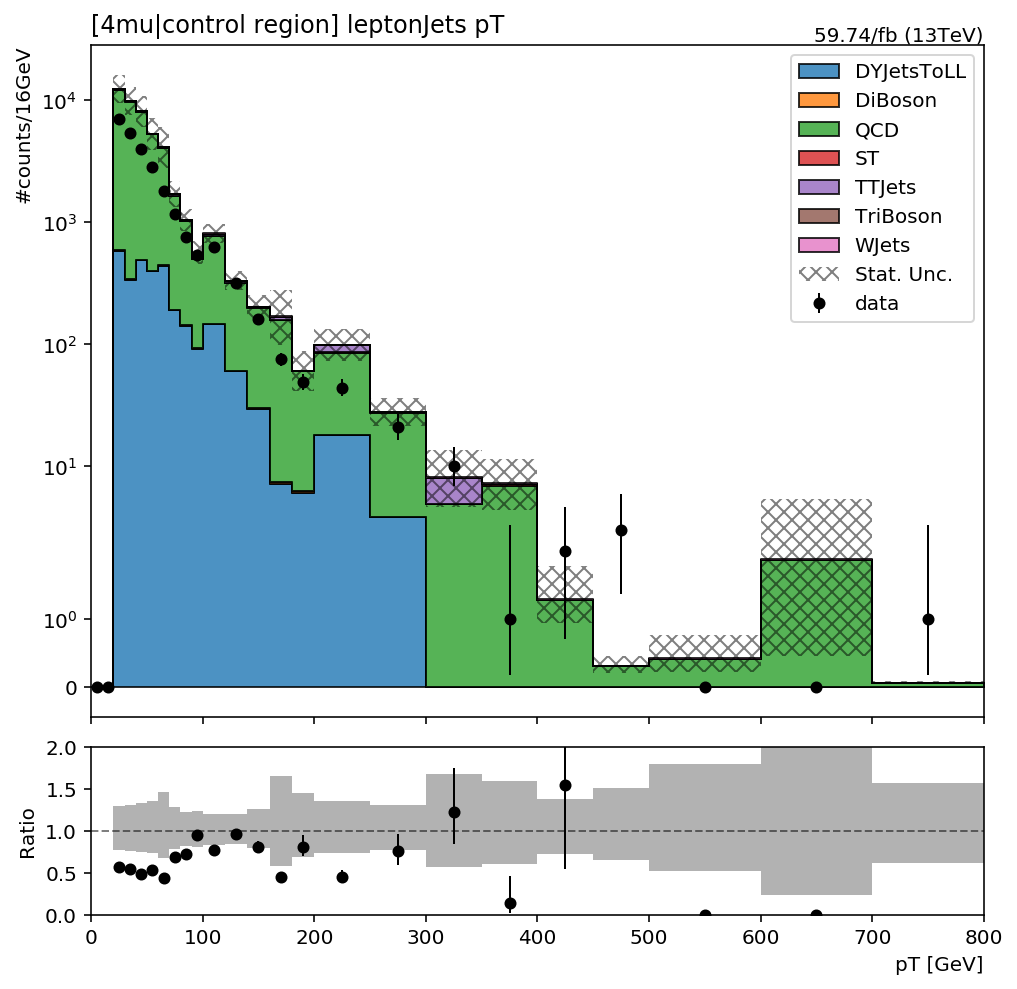

In [30]:
makeplot('pt_cat', 'leptonJets pT');

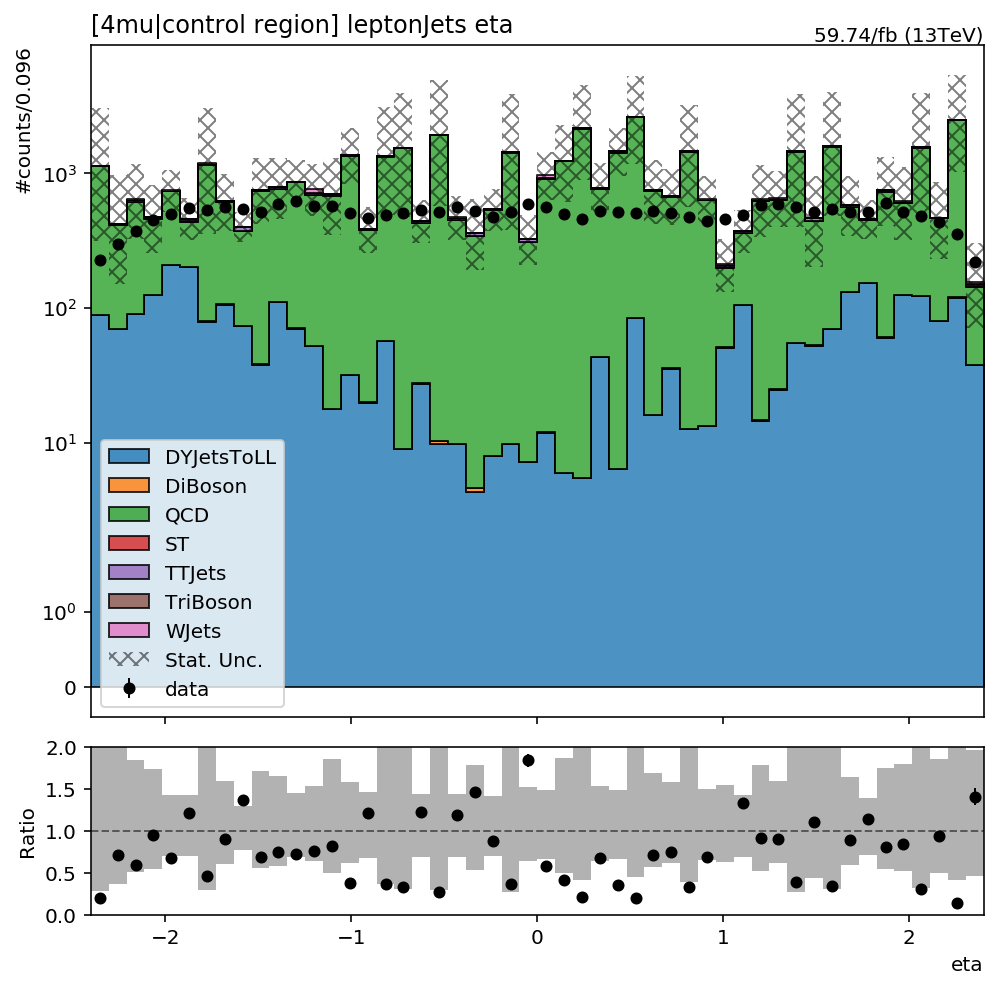

In [31]:
makeplot('eta_cat', 'leptonJets eta', overflow='none');

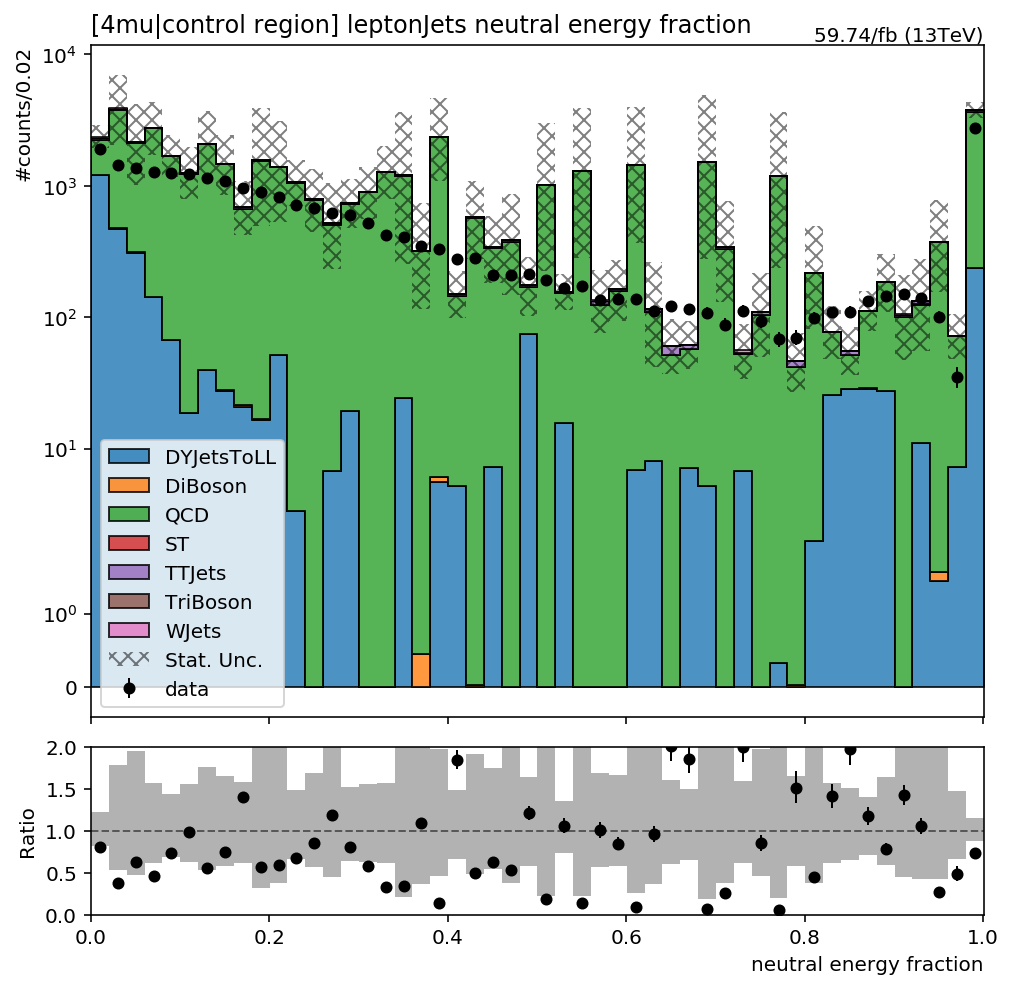

In [32]:
makeplot('nef_cat', 'leptonJets neutral energy fraction', overflow='none');

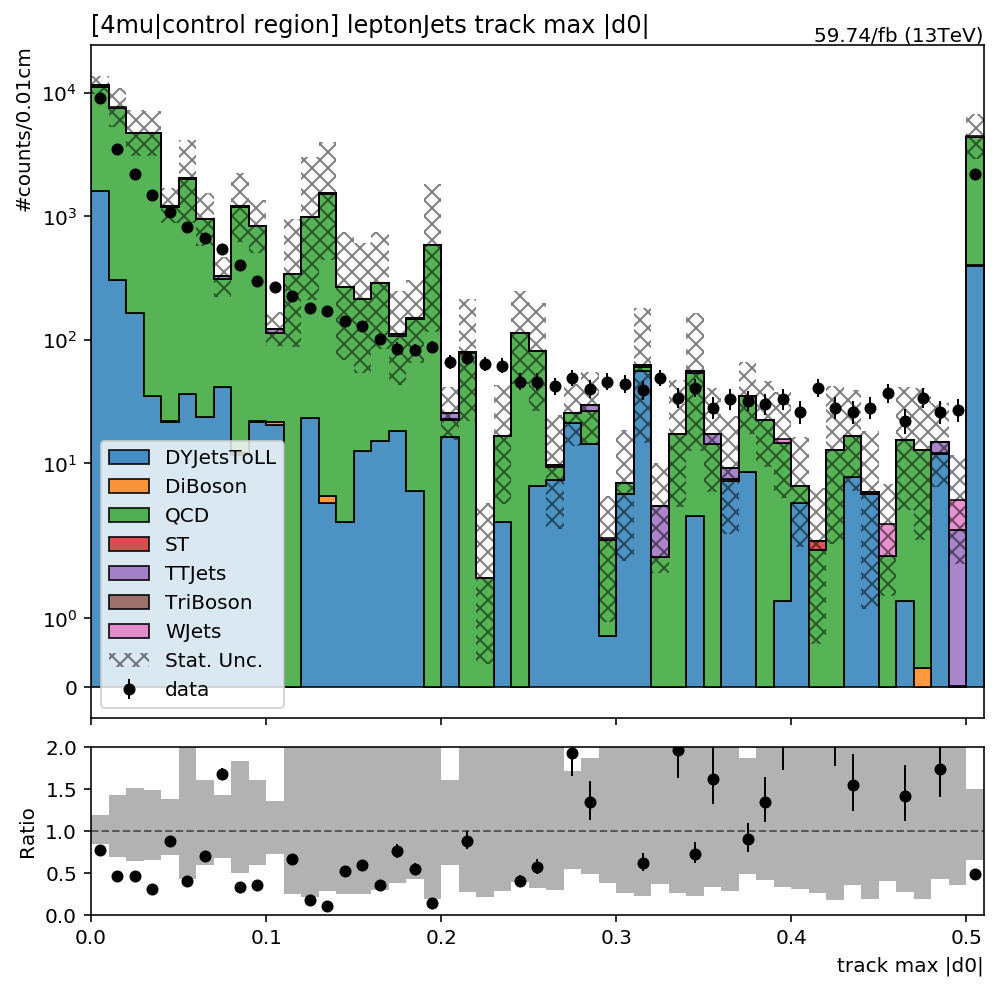

In [33]:
makeplot('maxd0_cat', 'leptonJets track max |d0|');

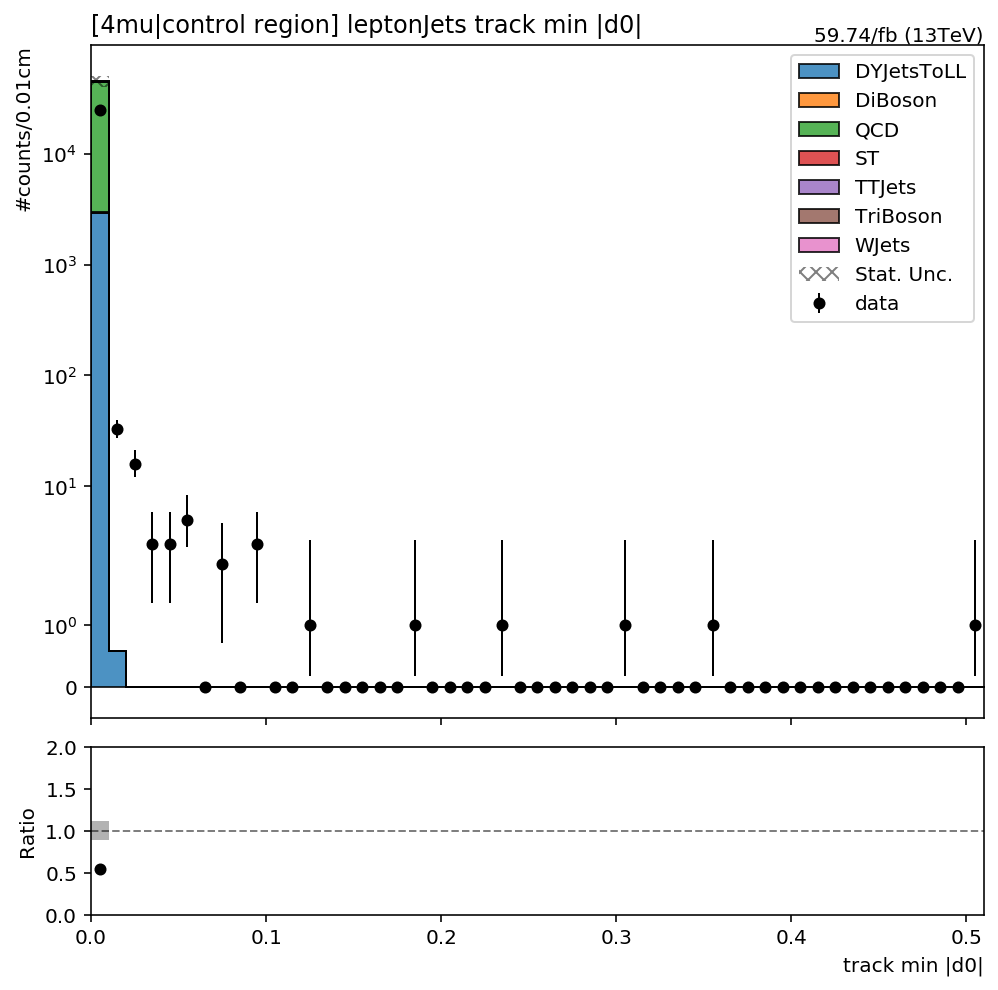

In [34]:
makeplot('mind0_cat', 'leptonJets track min |d0|');

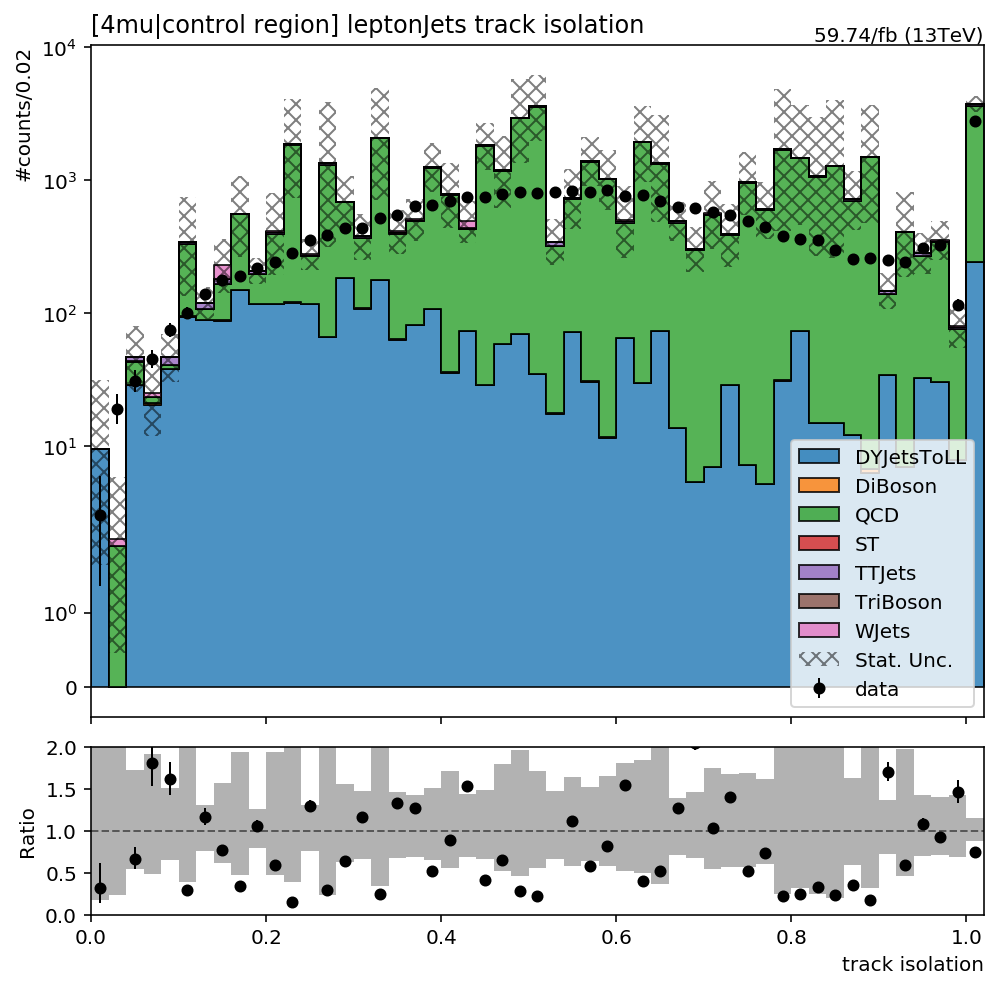

In [35]:
makeplot('tkiso_cat', 'leptonJets track isolation');

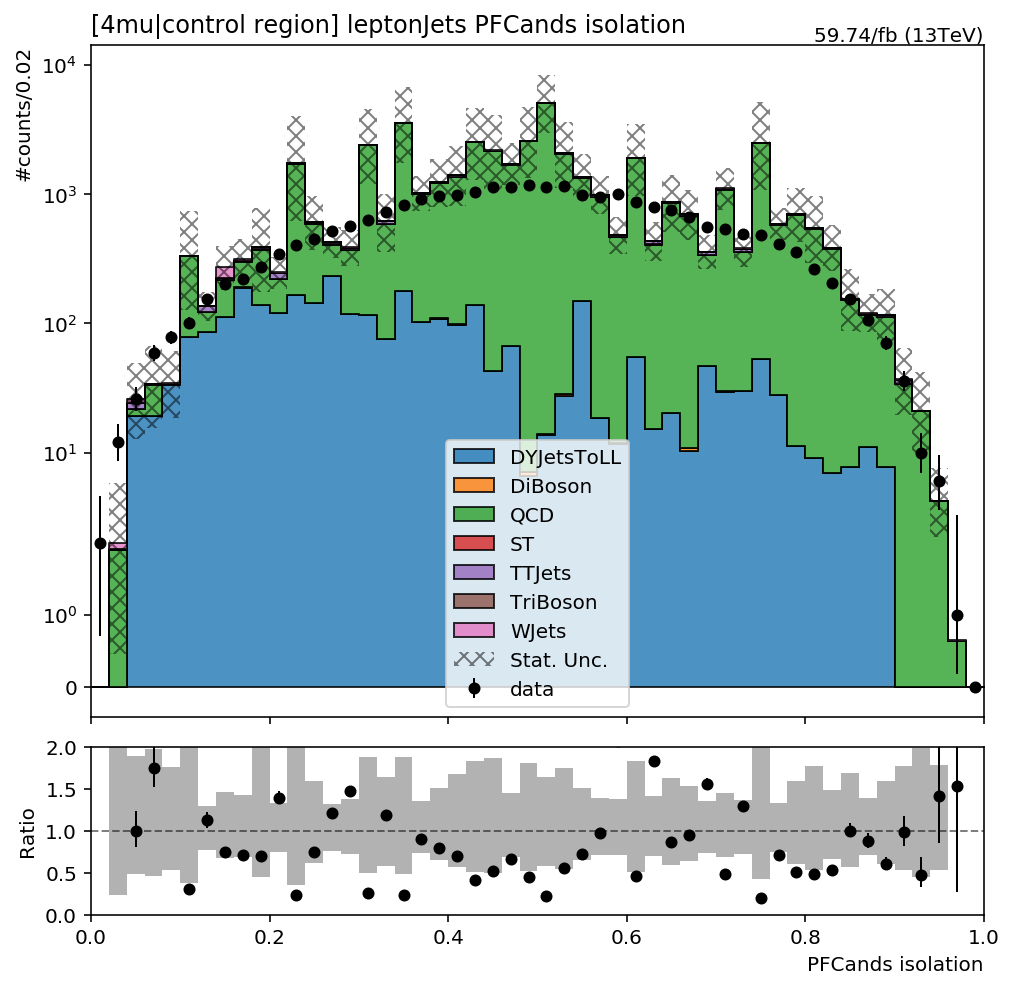

In [36]:
makeplot('pfiso_cat', 'leptonJets PFCands isolation', overflow='none');

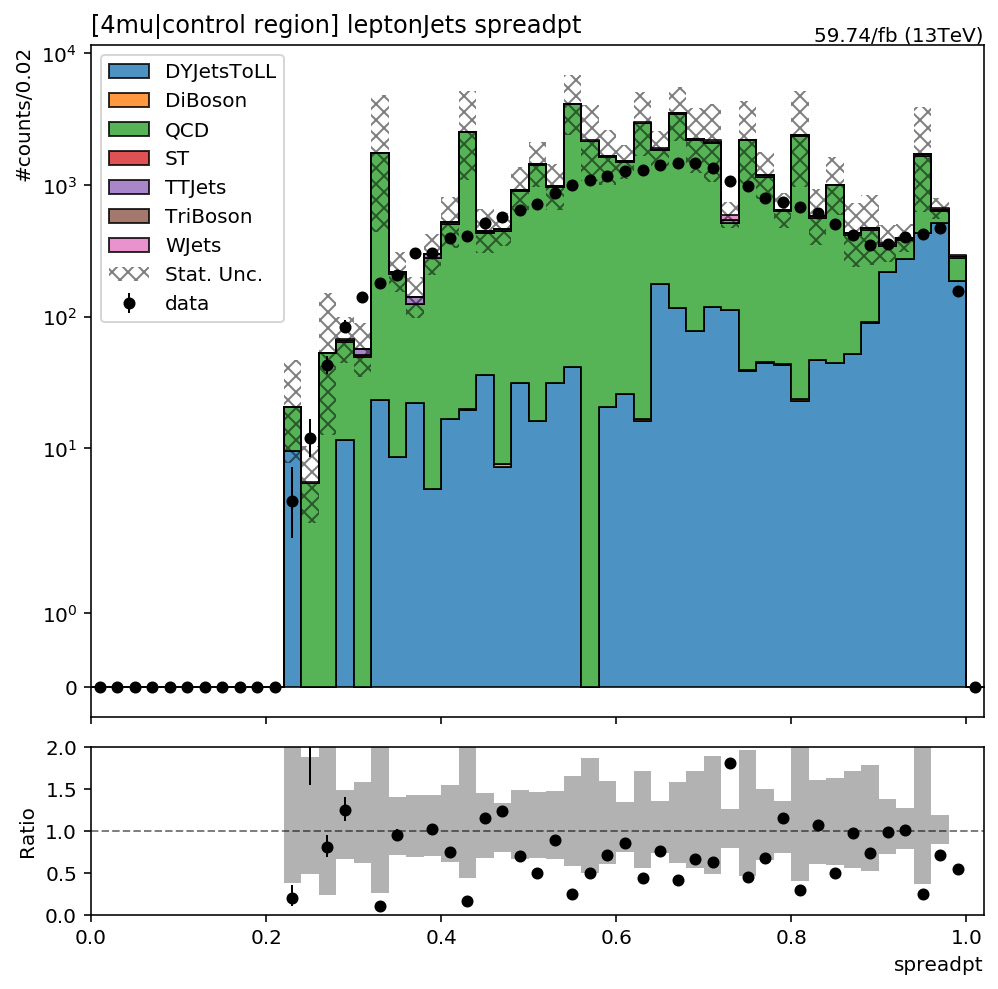

In [37]:
makeplot('spreadpt_cat', 'leptonJets spreadpt');

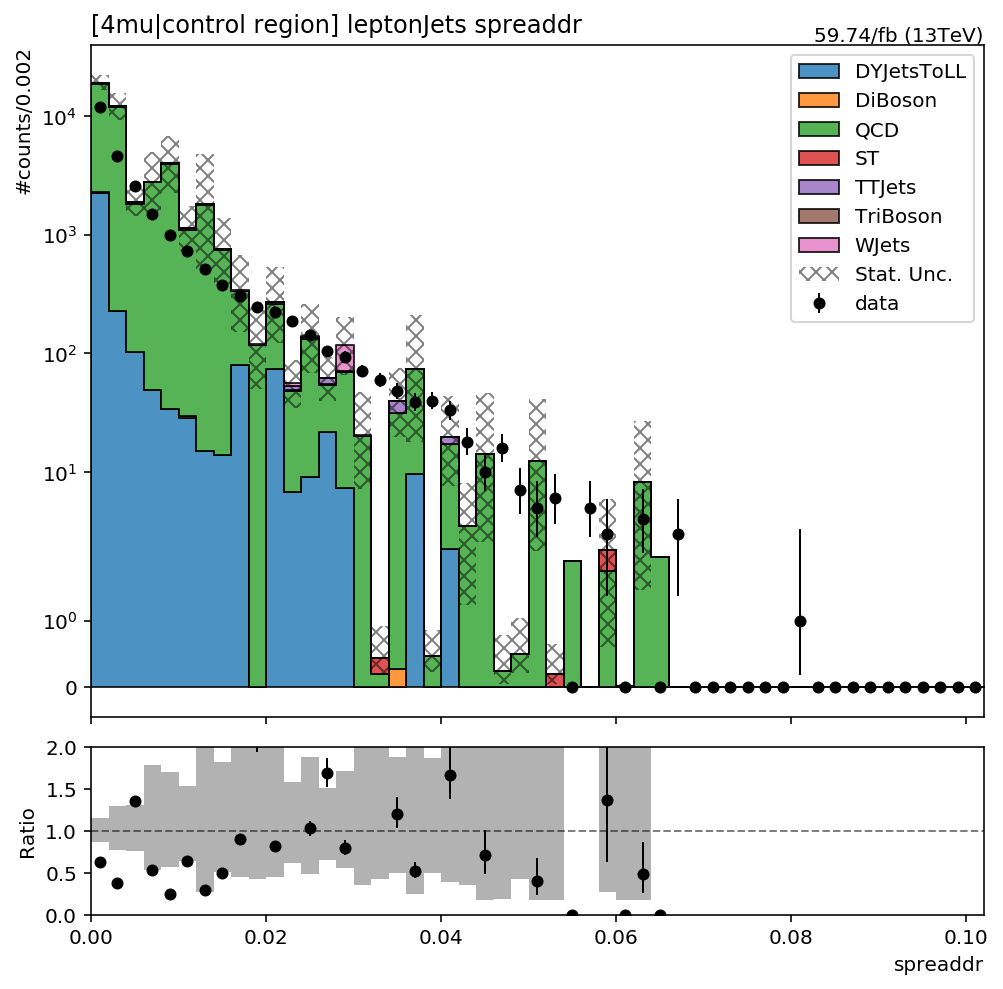

In [38]:
makeplot('spreaddr_cat', 'leptonJets spreaddr');

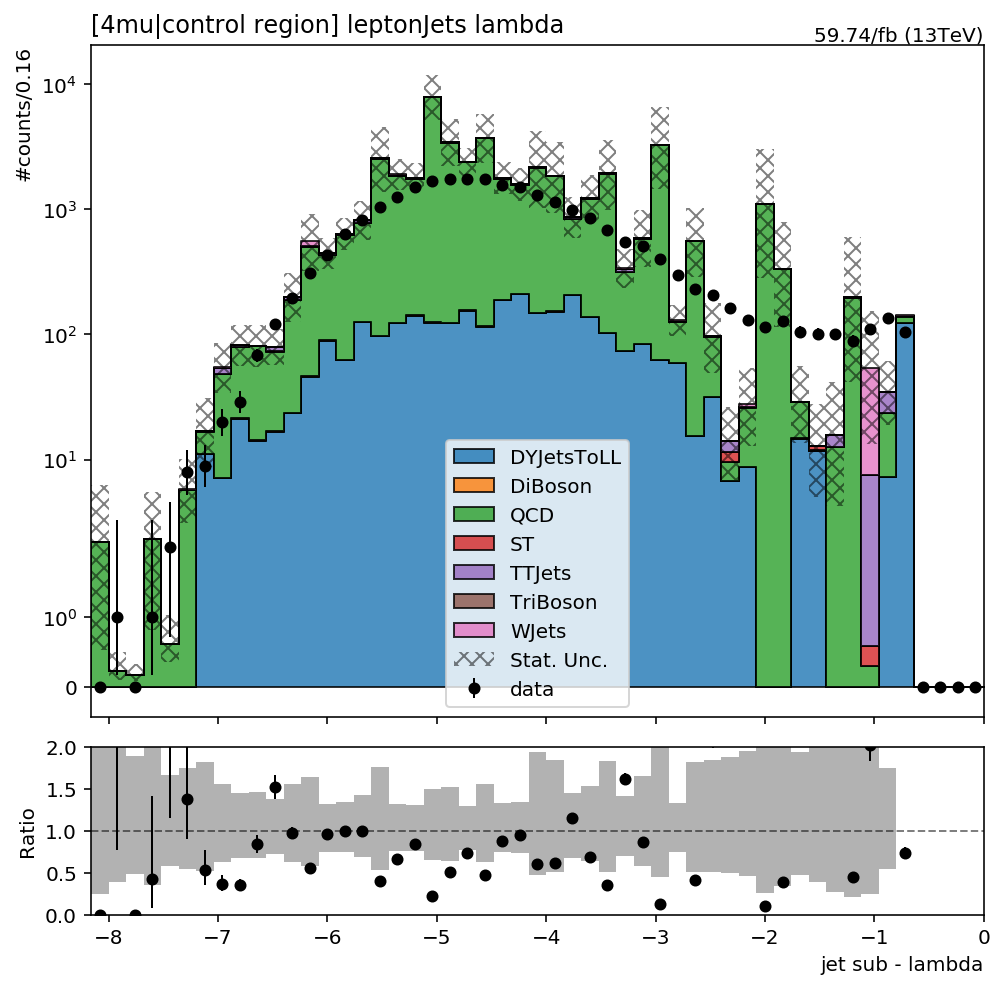

In [39]:
makeplot('lamb_cat', 'leptonJets lambda', overflow='under');

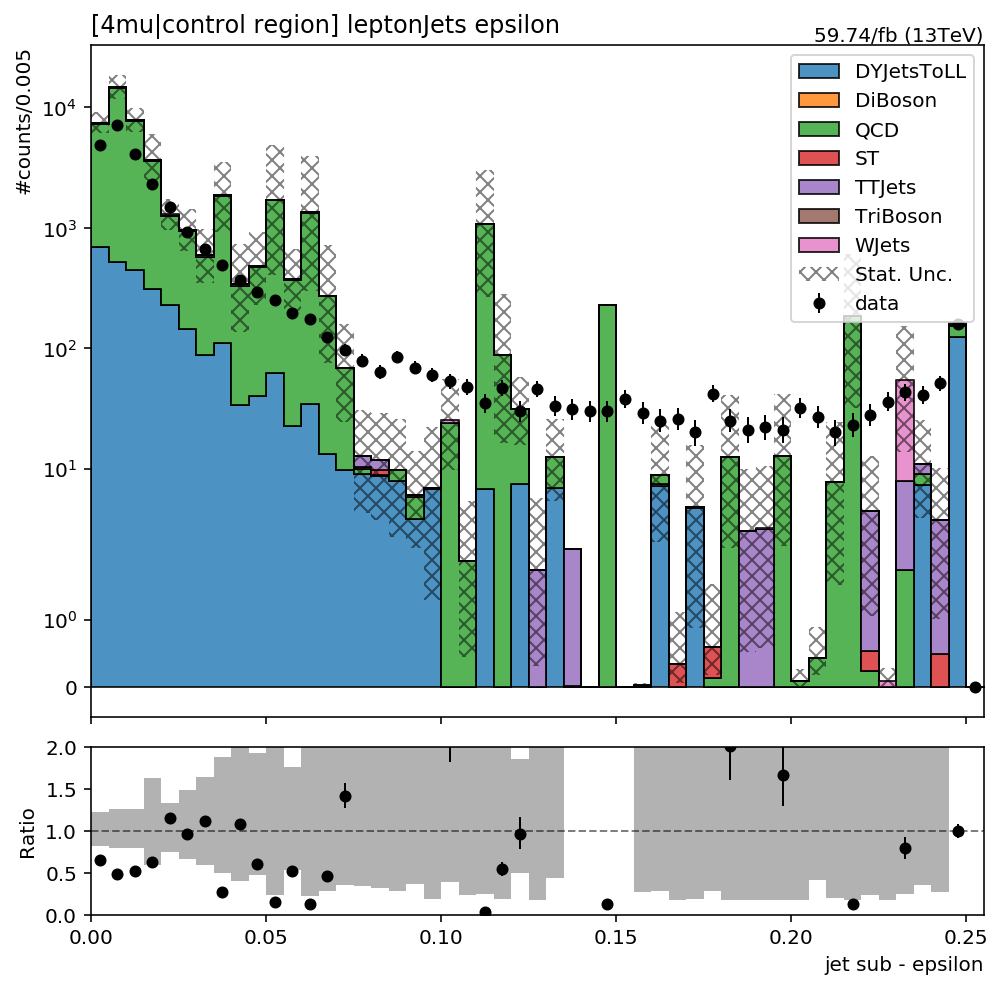

In [40]:
makeplot('epsi_cat', 'leptonJets epsilon');

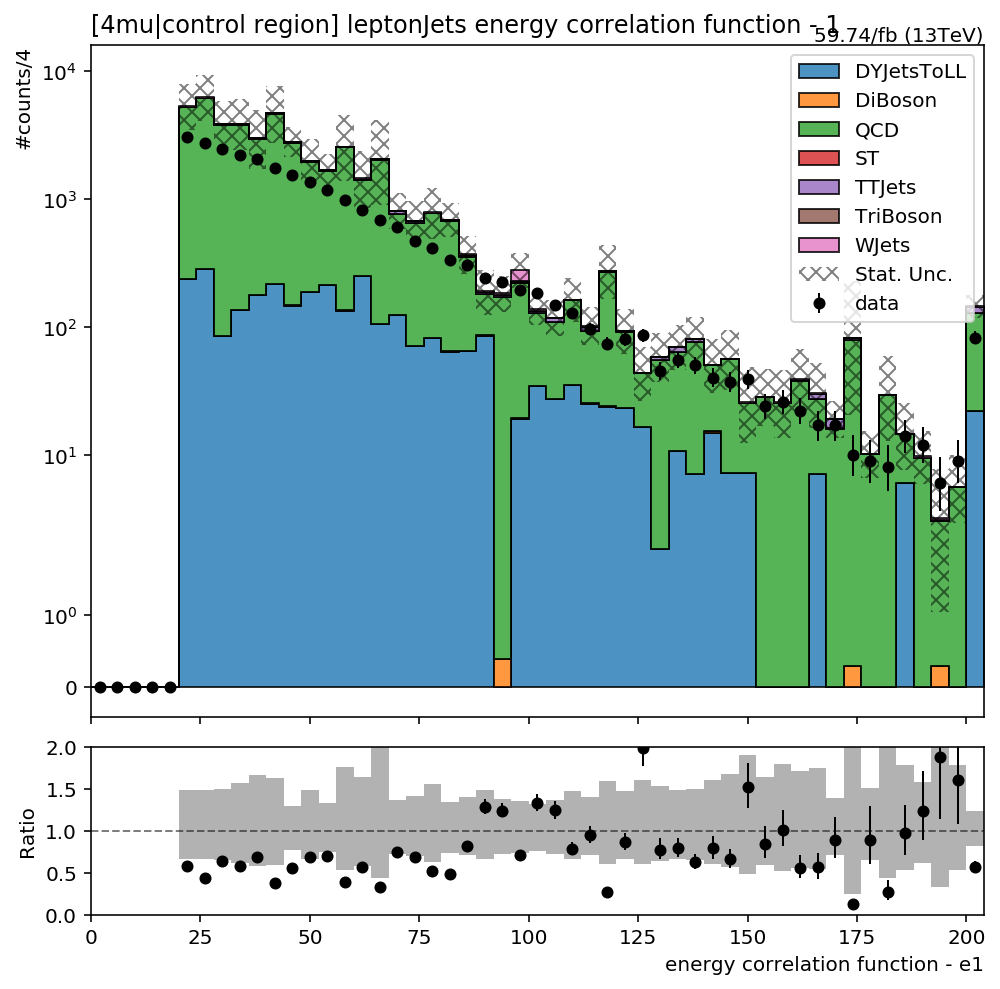

In [41]:
makeplot('ecfe1_cat', 'leptonJets energy correlation function - 1');

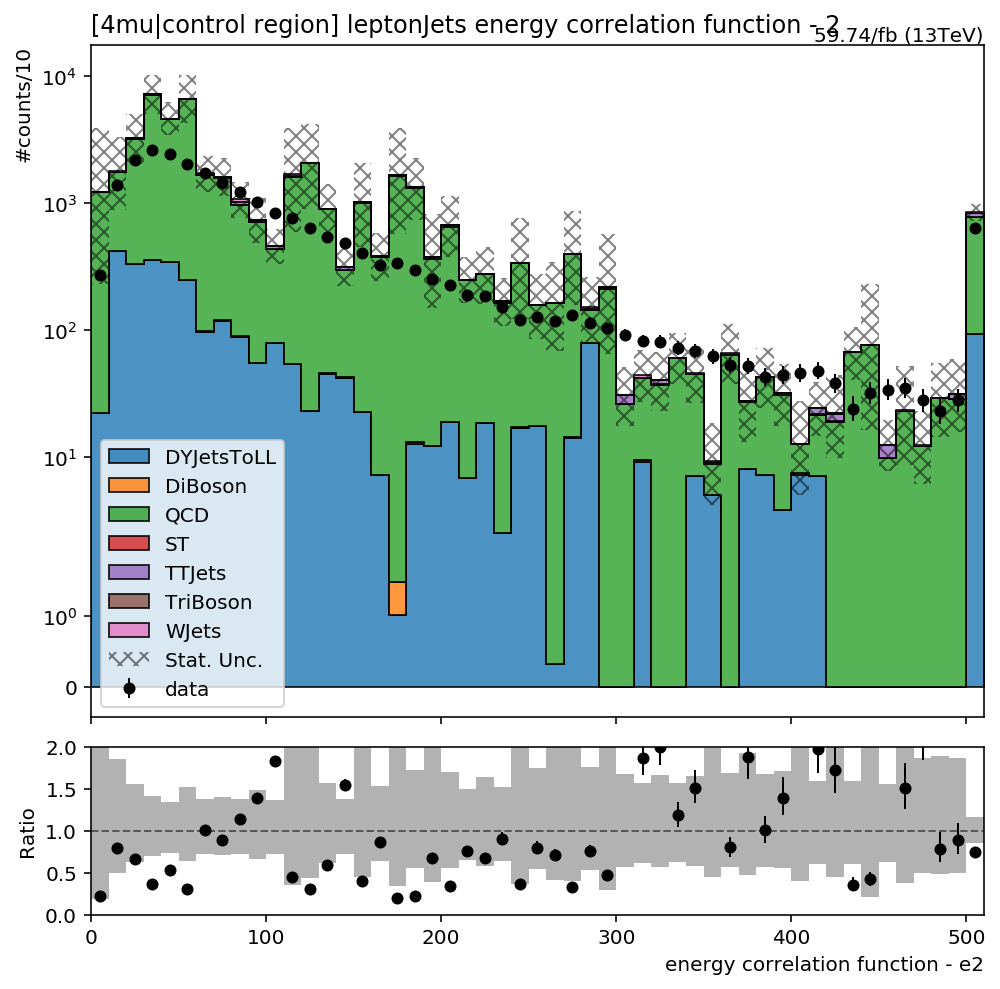

In [42]:
makeplot('ecfe2_cat', 'leptonJets energy correlation function - 2');

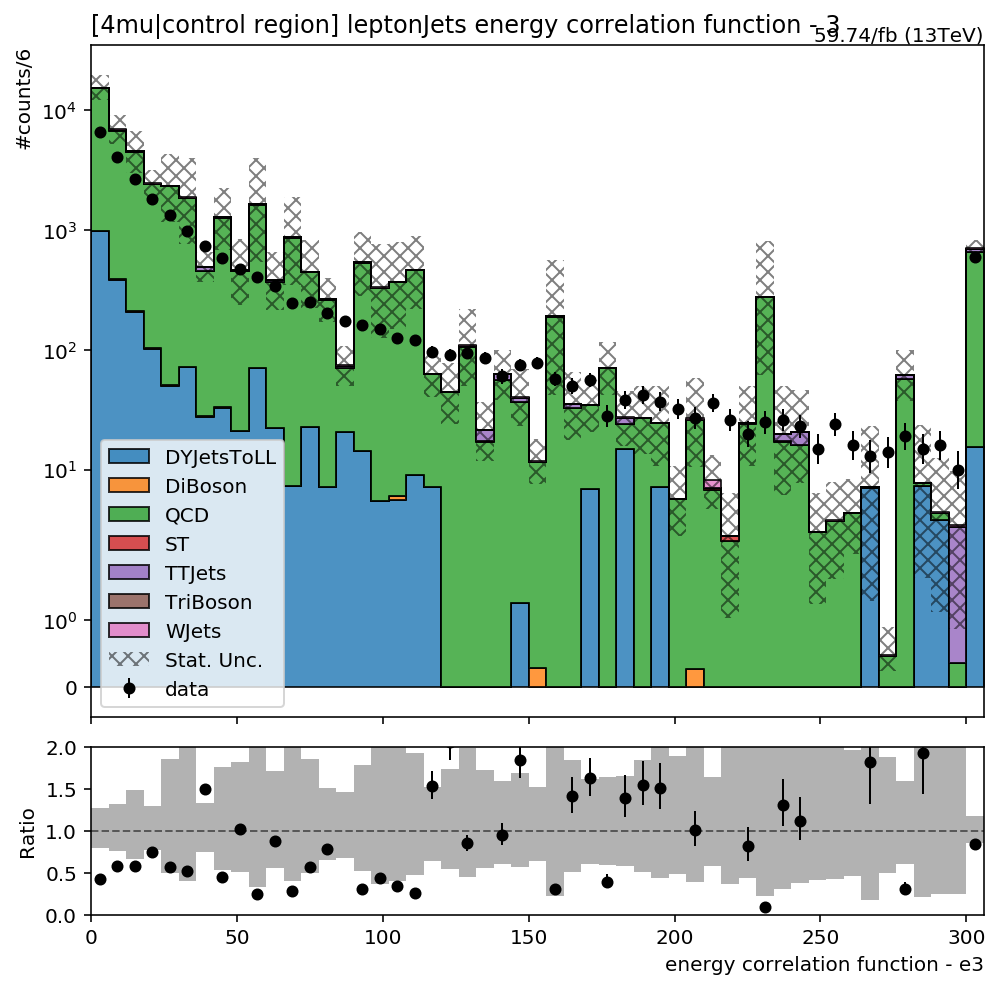

In [43]:
makeplot('ecfe3_cat', 'leptonJets energy correlation function - 3');